In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from prophet import Prophet
from datetime import timedelta
import statsmodels.api as sm
from mmm_tools.model_quality_estimation import SMAPE

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def saturation_effect(x_t, mu):
    """
    Вычисляет эффект насыщения по формуле:
    x_t^saturation = (1 - e^(-mu * x_t)) / (1 + e^(-mu * x_t))

    Параметры:
    x_t (float или np.array): Значение рекламных инвестиций или активности.
    mu (float): Параметр, определяющий форму кривой насыщения.

    Возвращает:
    float или np.array: Значение эффекта насыщения.
    """
    numerator = 1 - np.exp(-mu * x_t)
    denominator = 1 + np.exp(-mu * x_t)
    return numerator / denominator

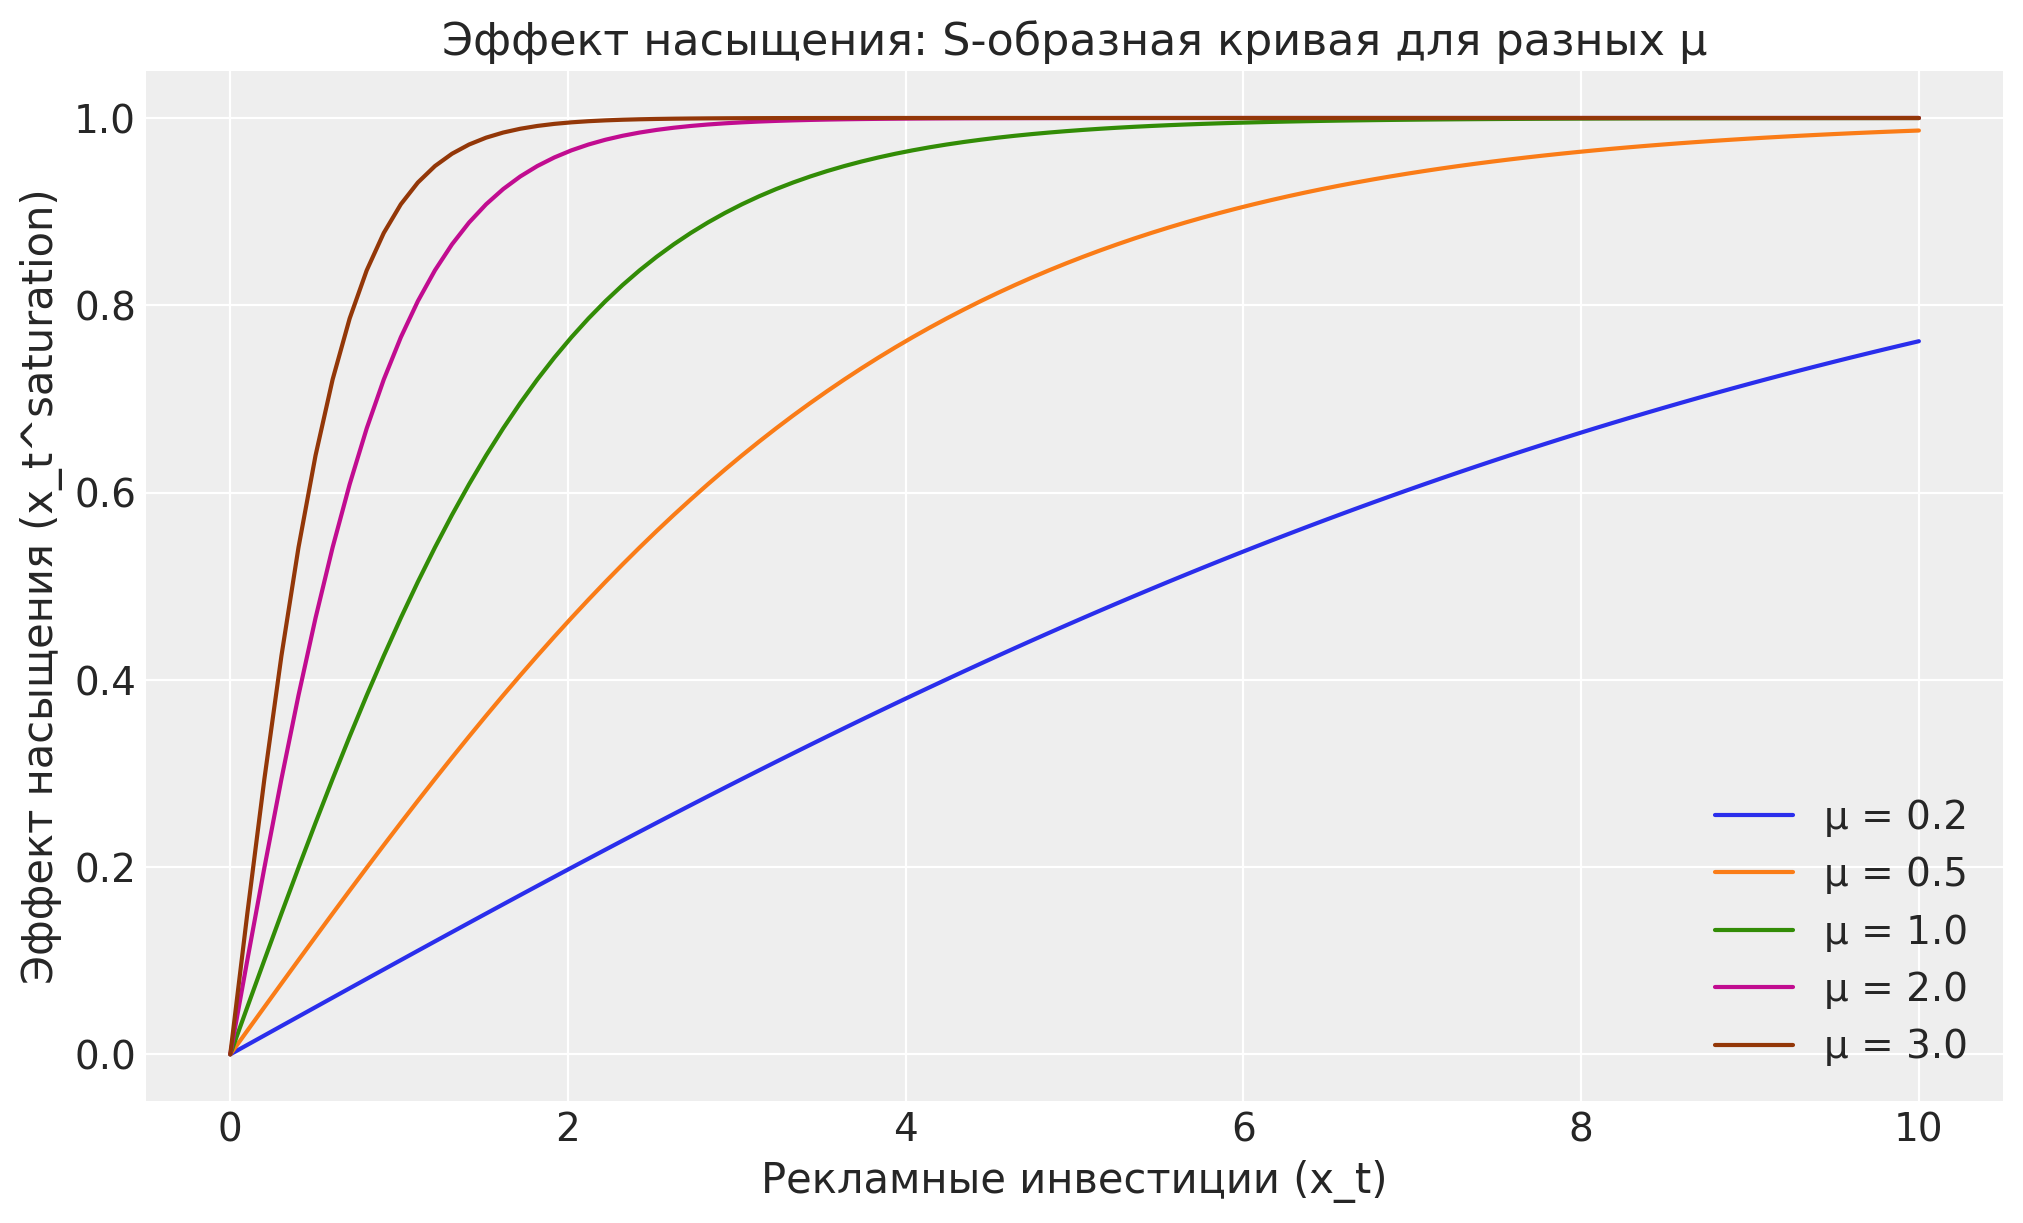

In [3]:
# Диапазон значений рекламных инвестиций
x_values = np.linspace(0, 10, 100)

# Разные значения параметра mu
mu_values = [0.2, 0.5, 1.0, 2.0, 3.0]

# Визуализация
plt.figure(figsize=(10, 6))

for mu in mu_values:
    saturation_values = saturation_effect(x_values, mu)
    plt.plot(x_values, saturation_values, label=f"μ = {mu}")

plt.title("Эффект насыщения: S-образная кривая для разных μ")
plt.xlabel("Рекламные инвестиции (x_t)")
plt.ylabel("Эффект насыщения (x_t^saturation)")
plt.legend()
plt.grid(True)
plt.show()

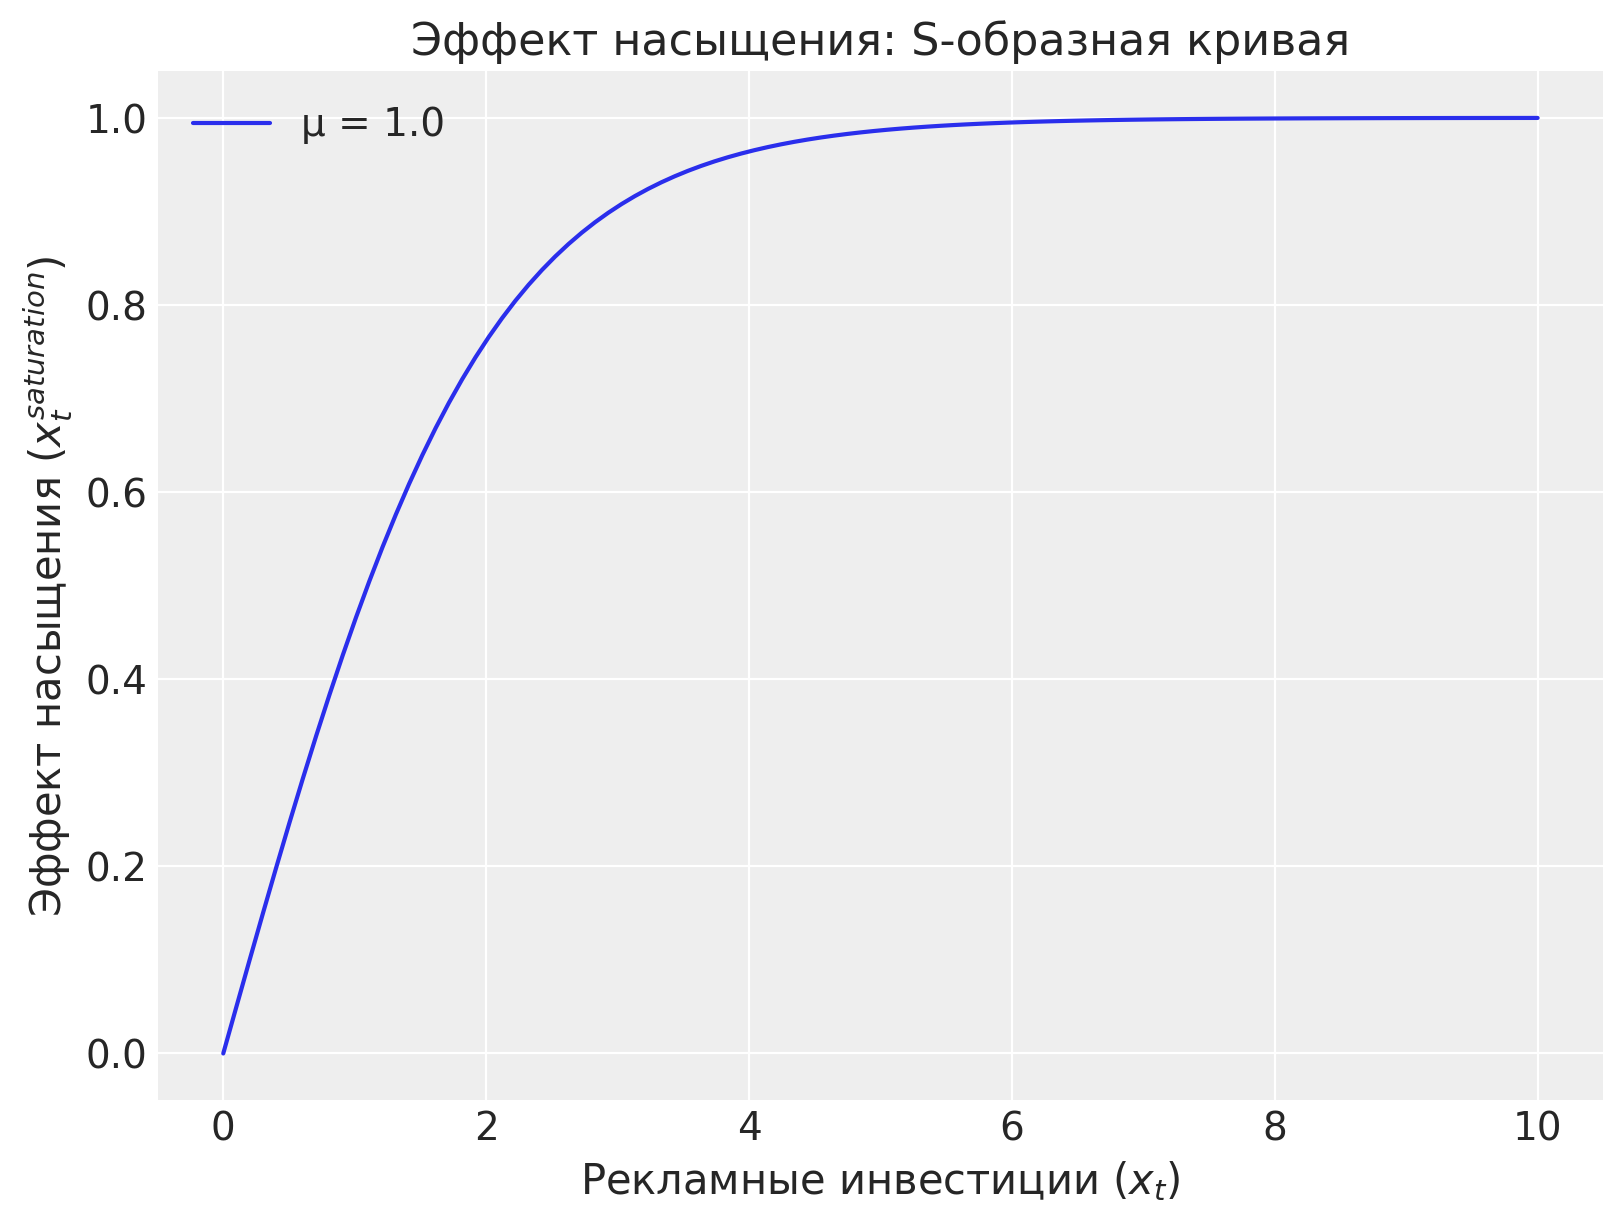

In [4]:
# Пример использования
x_values = np.linspace(0, 10, 100)  # Диапазон значений рекламных инвестиций
mu = 1.0  # Параметр насыщения

# Вычисляем эффект насыщения для каждого значения x_t
saturation_values = saturation_effect(x_values, mu)

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(x_values, saturation_values, label=f"μ = {mu}")
plt.title("Эффект насыщения: S-образная кривая")
plt.xlabel("Рекламные инвестиции ($x_t$)")
plt.ylabel("Эффект насыщения ($x_t^{saturation})$")
plt.legend()
plt.grid(True)
plt.show()

### Import data

In [5]:
import os 
os.getcwd()

'/Users/i.nuriev/repository/work_space/MMM/science'

In [6]:
df = pd.read_excel('data/df_for_modelling.xlsx')
df.set_index('date',inplace=True)

media_360_cols = ['tv_nat_ots_ta_14_54',
                  'media_outdoor_total_ots_geo',
                  'digital_media_total_ots_total',
                  'bloggers_ots_total']


media_chanels = ['tv','ooh','digital_media','bloggers']

df['tv'] = df[['tv_nat_ots_ta_14_54_flight_5','tv_nat_ots_shows_ta_14_54']].sum(axis=1).loc['2024-08-01':]
df['ooh'] = df.media_outdoor_total_ots_geo_flight_5
df['digital_media'] = df[['digital_media_total_ots_total_flight_5','digital_media_shows_ots_total','digital_media_others_ots_total']].sum(axis=1).loc['2024-08-01':]
df['bloggers'] = df[['bloggers_ots_total_flight_5','bloggers_shows_ots_total','bloggers_others_ots_total']].sum(axis=1).loc['2024-08-01':]

### Media transformation

In [7]:
# apply geometric adstock transformation
alpha_tv: float = 0.6
alpha_ooh: float = 0.7
alpha_dm: float = 0.3

df["tv_adstock"] = (
    geometric_adstock(x=df["tv"].to_numpy(), alpha=alpha_tv, l_max=14, normalize=True)
    .eval()
    .flatten()
)

df["ooh_adstock"] = (
    geometric_adstock(x=df["ooh"].to_numpy(), alpha=alpha_ooh, l_max=14, normalize=True)
    .eval()
    .flatten()
)

df["dm_adstock"] = (
    geometric_adstock(x=df["digital_media"].to_numpy(), alpha=alpha_dm, l_max=14, normalize=True)
    .eval()
    .flatten()
)

In [8]:
# apply saturation transformation
lam_tv: float = 4.0
lam_ooh: float = 3.0
lam_dm: float = 3.0

df["tv_adstock_saturated"] = logistic_saturation(
    x=df["tv_adstock"].to_numpy(), lam=lam_tv
).eval()

df["ooh_adstock_saturated"] = logistic_saturation(
    x=df["ooh_adstock"].to_numpy(), lam=lam_ooh
).eval()

df["dm_adstock_saturated"] = logistic_saturation(
    x=df["dm_adstock"].to_numpy(), lam=lam_dm
).eval()

Text(0.5, 0.98, 'Media Costs Data - Transformed')

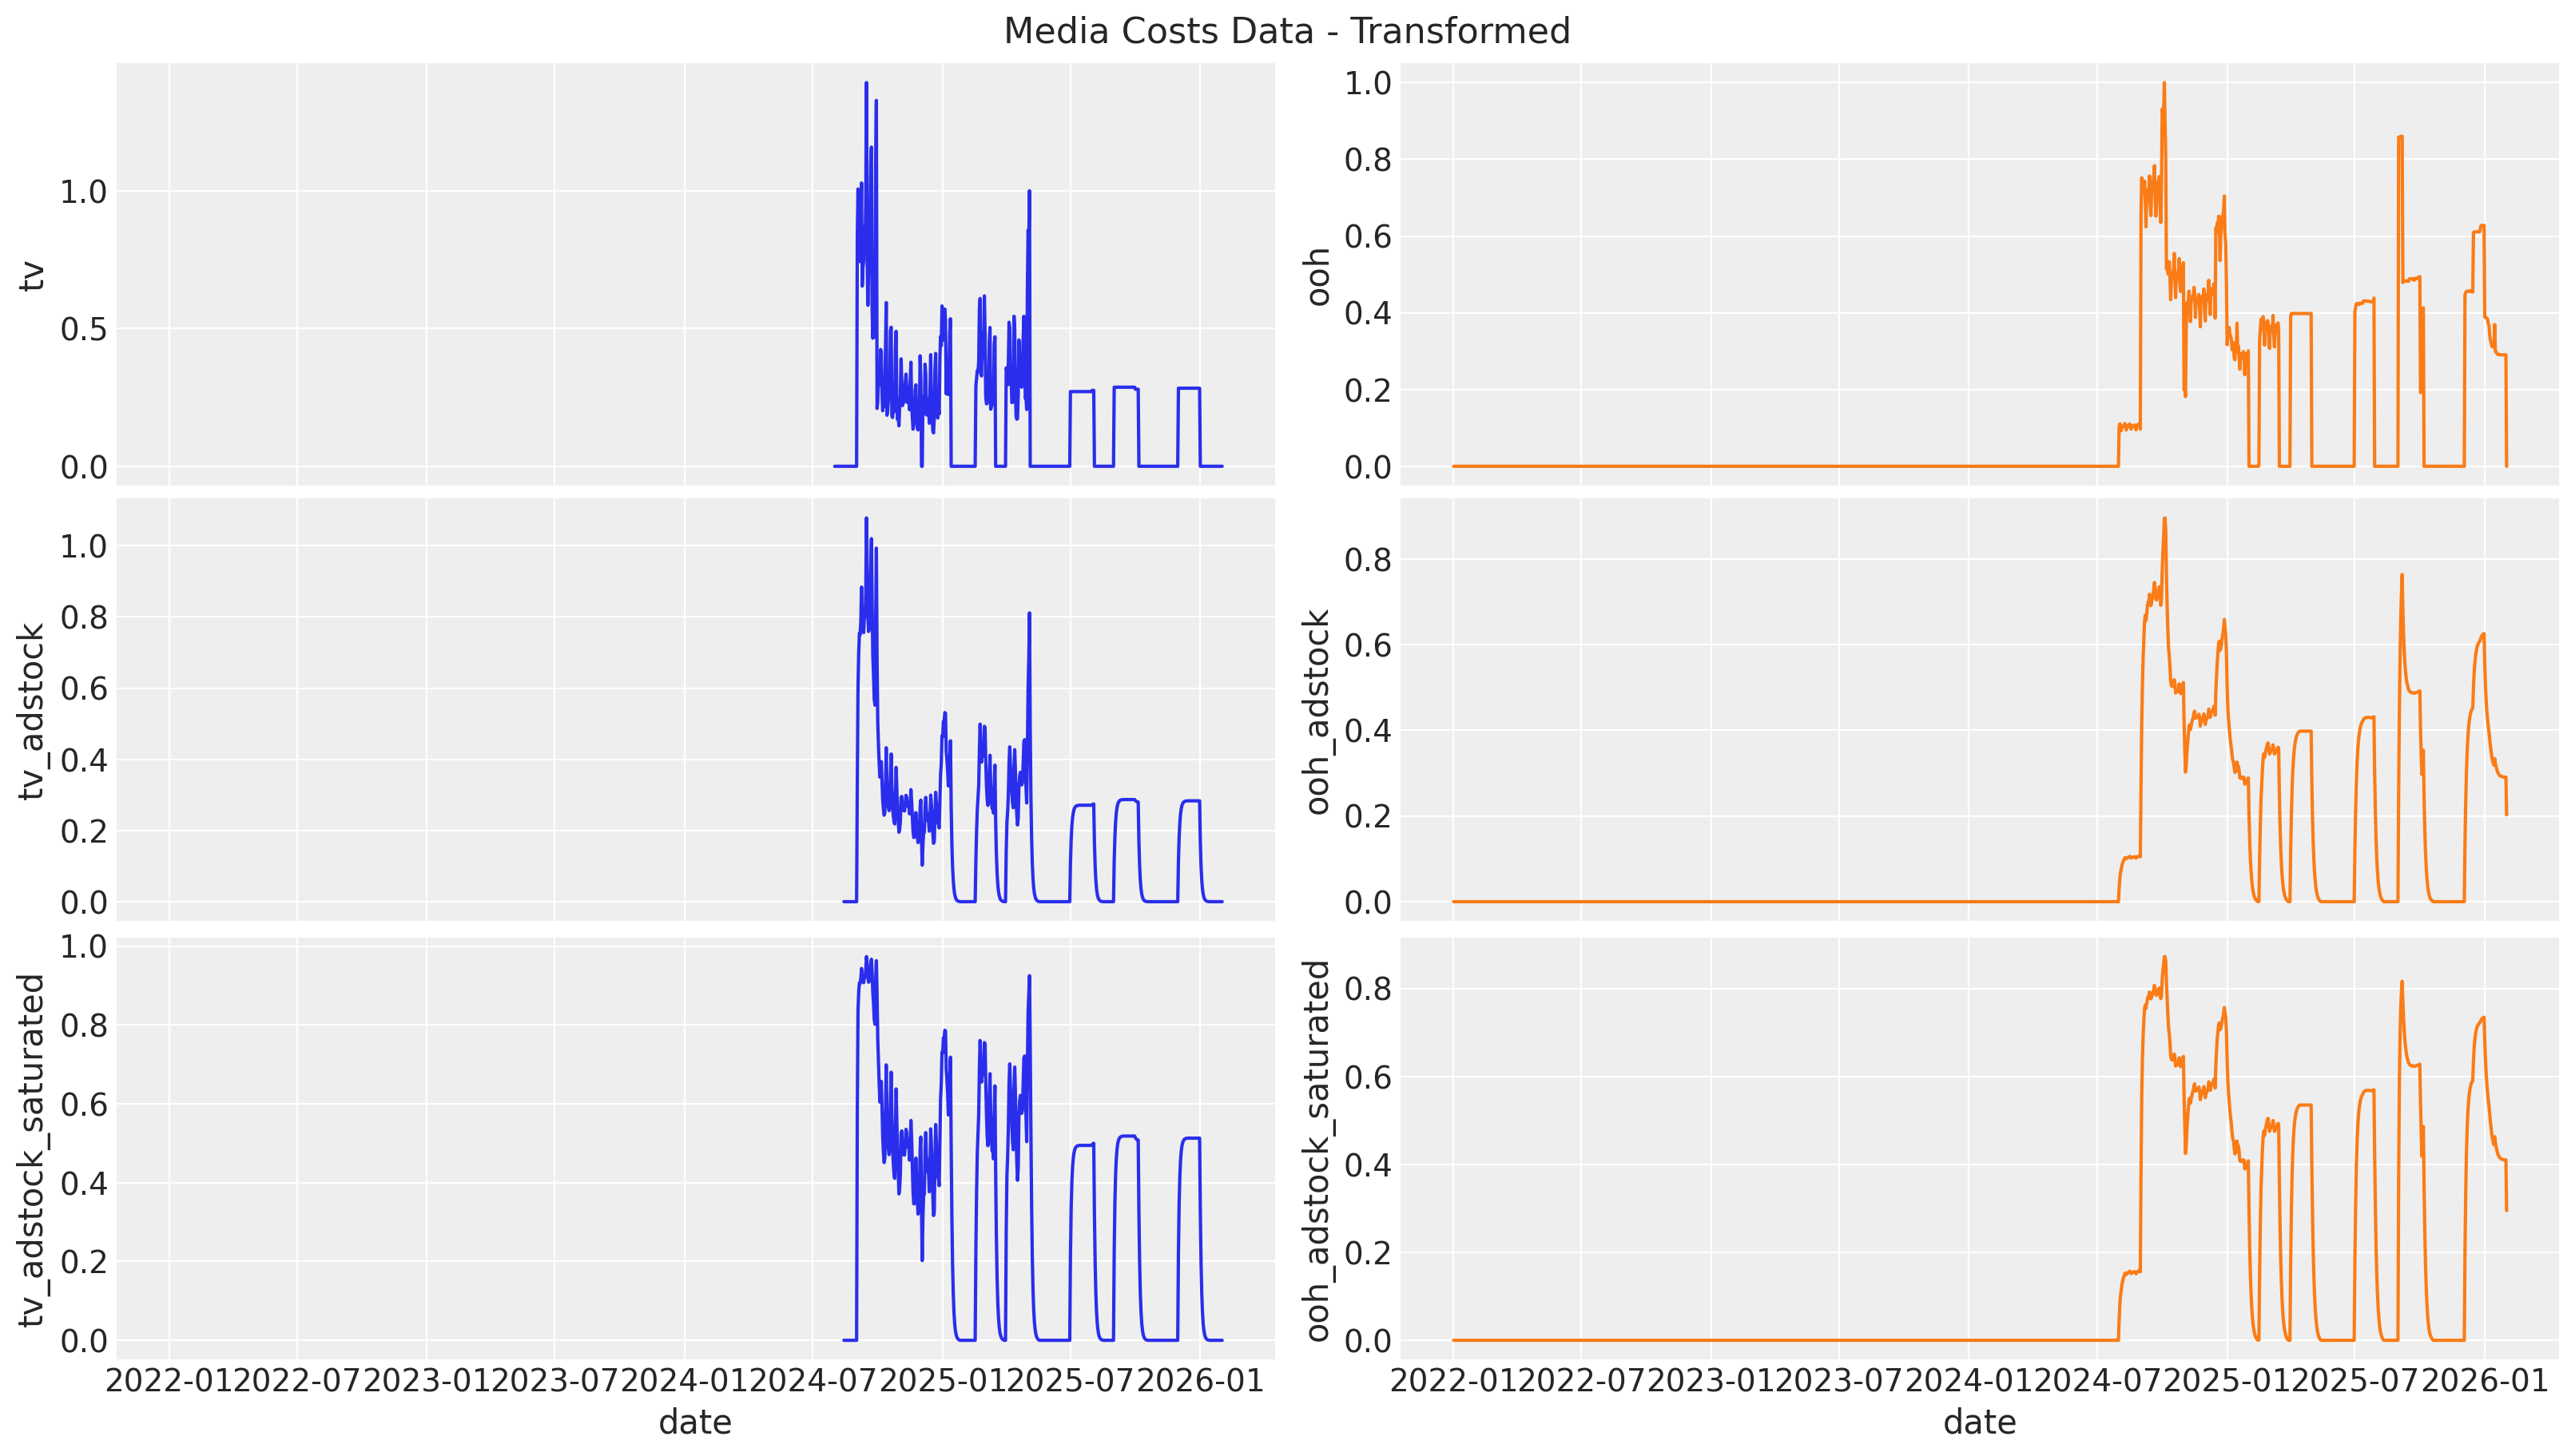

In [9]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="tv", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date", y="ooh", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date", y="tv_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date", y="ooh_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date", y="tv_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date", y="ooh_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16)

Text(0.5, 0.98, 'Media Costs Data - Transformed')

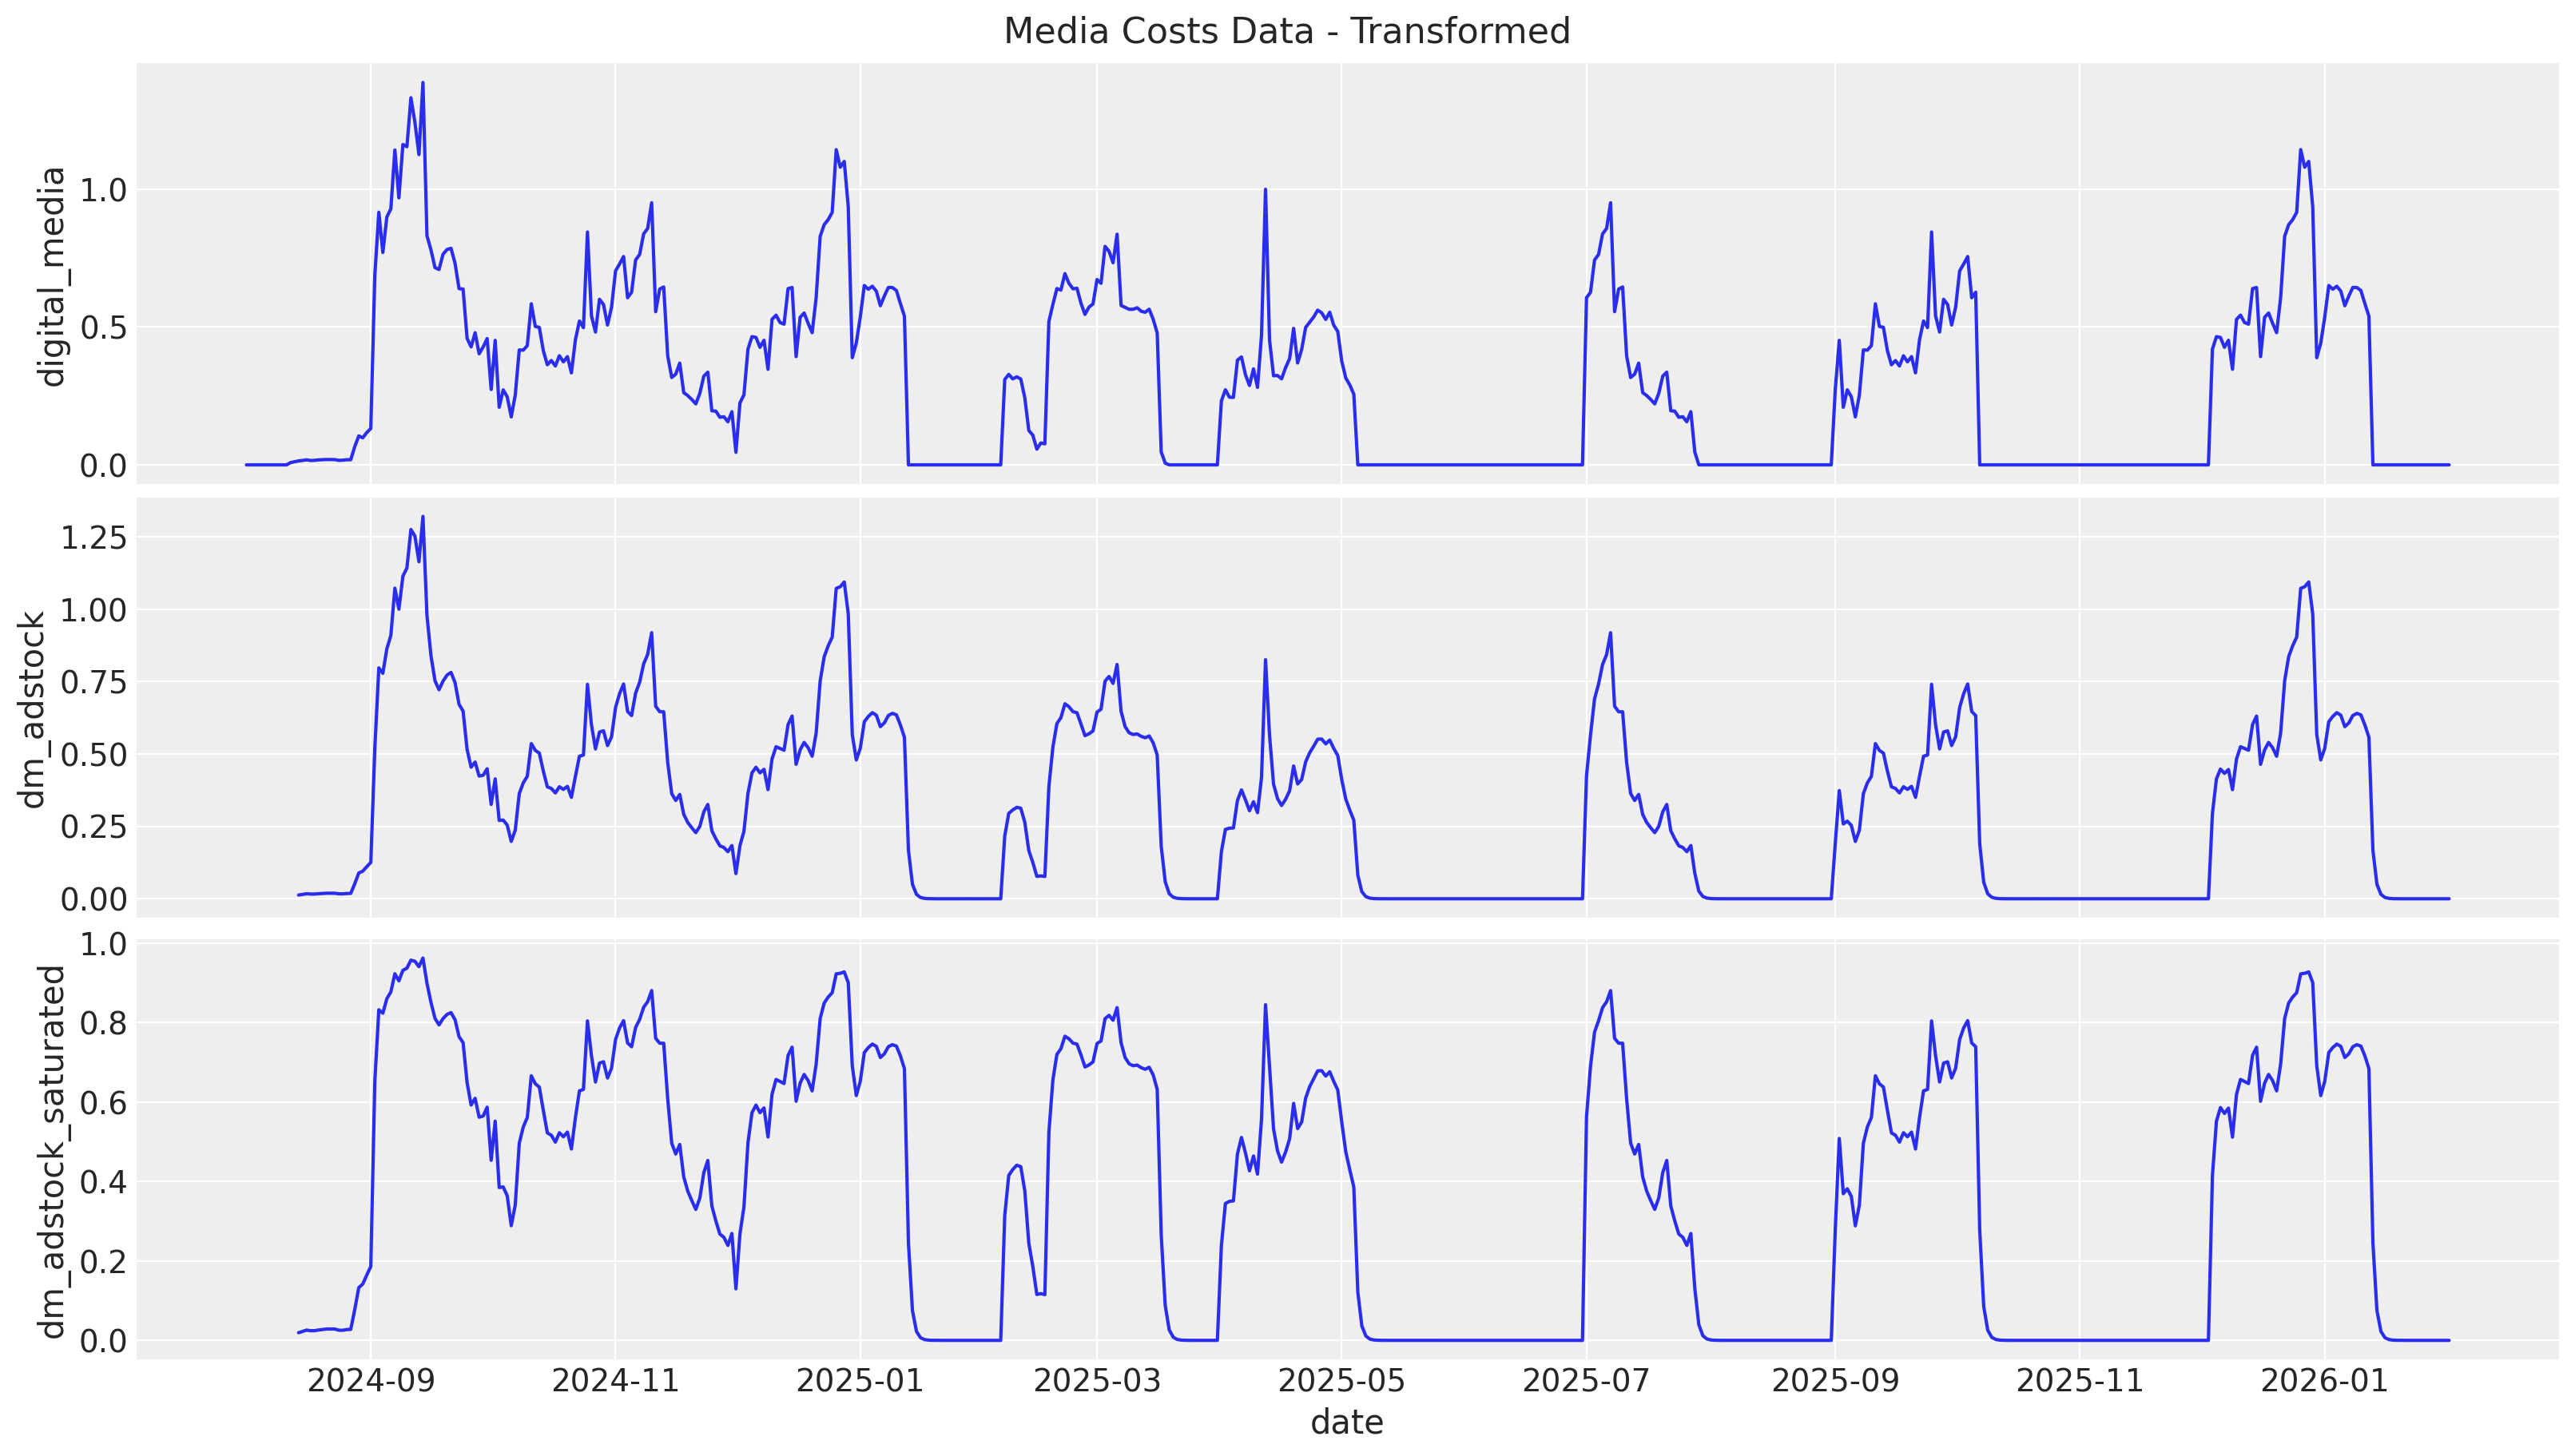

In [10]:
fig, ax = plt.subplots(
    nrows=3, ncols=1, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="digital_media", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date", y="dm_adstock", data=df, color="C0", ax=ax[1])
sns.lineplot(x="date", y="dm_adstock_saturated", data=df, color="C0", ax=ax[2])
fig.suptitle("Media Costs Data - Transformed", fontsize=16)

## Control variables

### Loss DAU

11:48:33 - cmdstanpy - INFO - Chain [1] start processing
11:48:33 - cmdstanpy - INFO - Chain [1] done processing
/Users/i.nuriev/Library/Caches/pypoetry/virtualenvs/mmm-tools-9U9JP_nD-py3.11/lib/python3.11/site-packages/prophet/plot.py:94: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


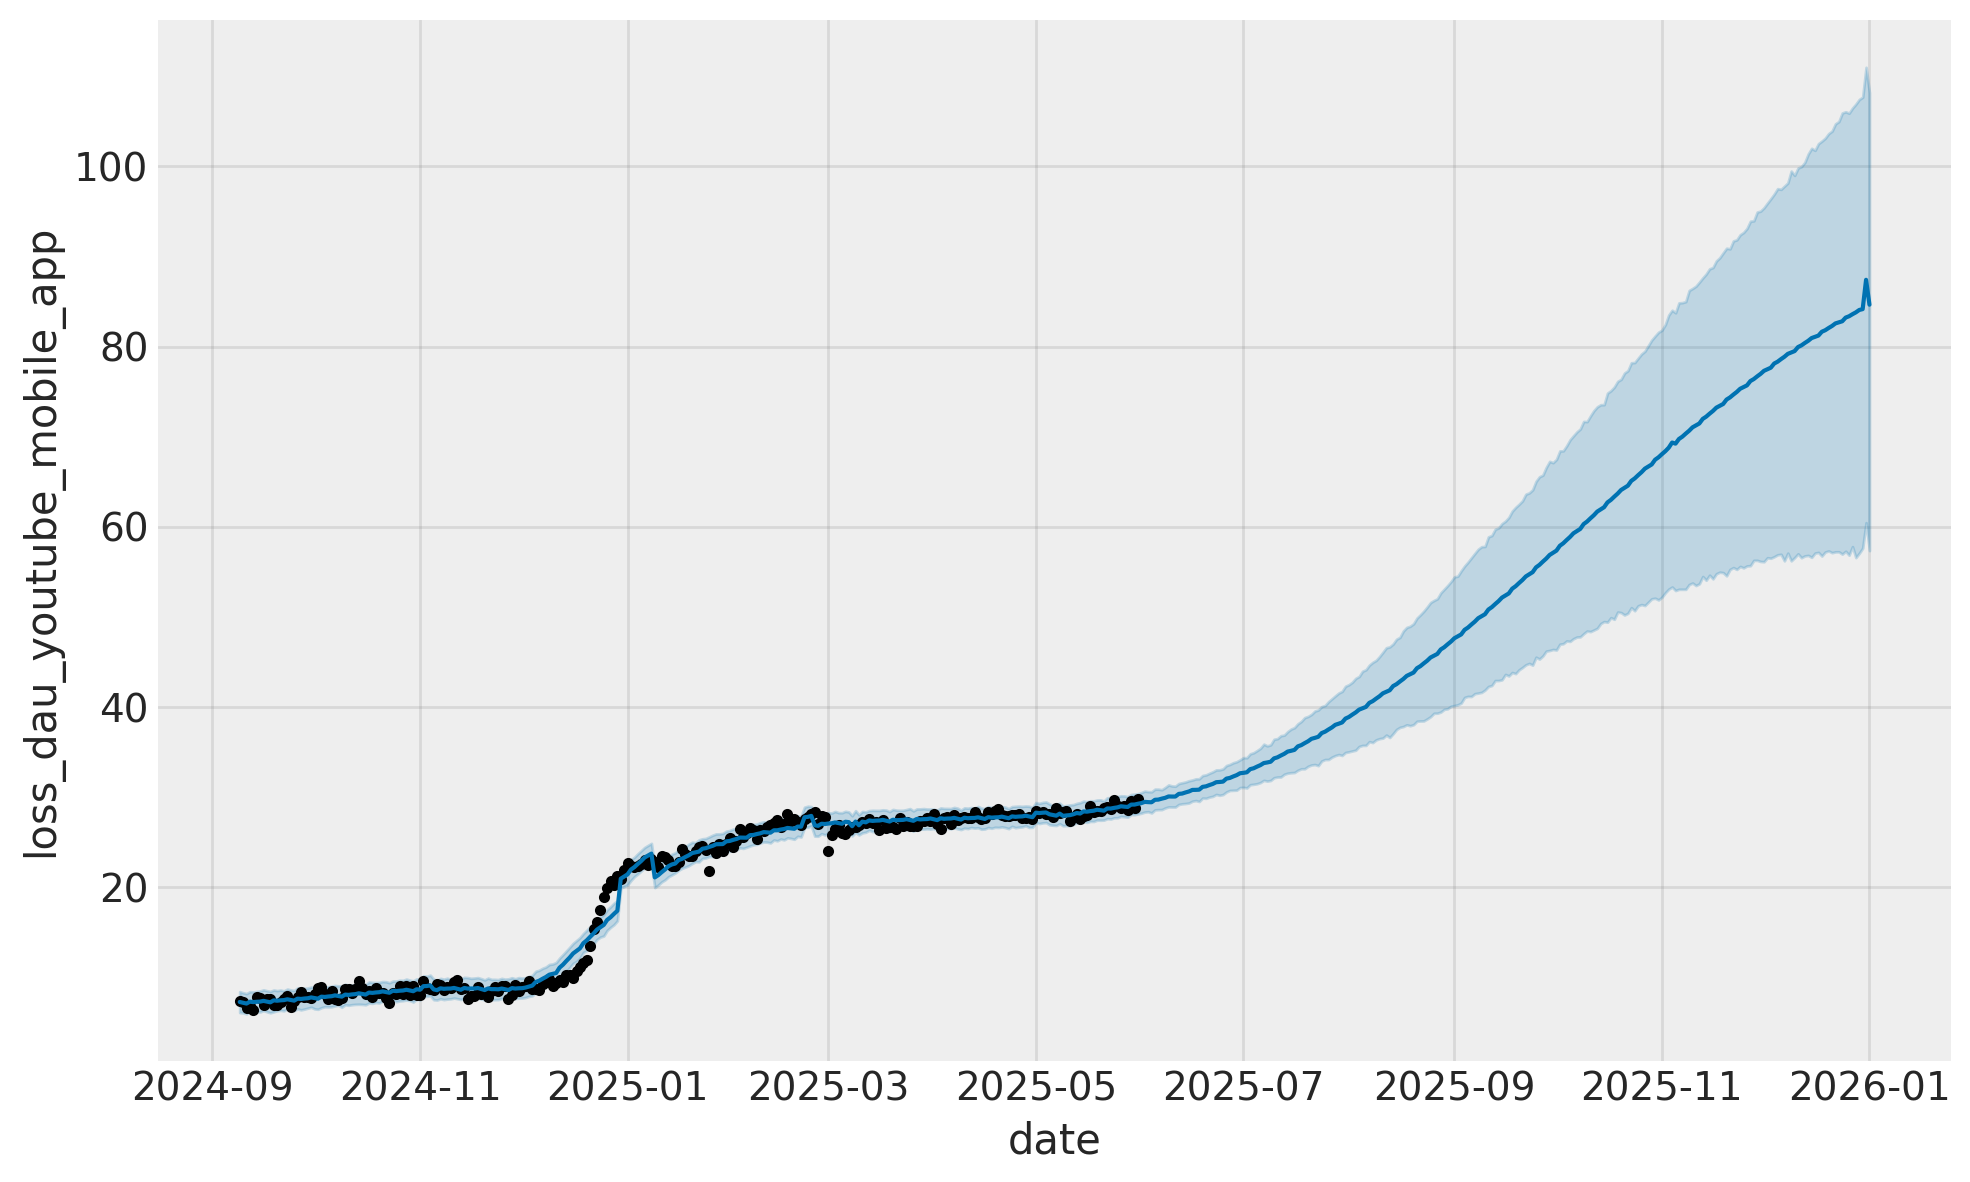

In [11]:
kpi = 'loss_dau_youtube_mobile_app'
date_start_dau_youtube = df[~df[kpi].eq(0)].index.min()
date_last_dau_youtube = df[~df[kpi].eq(0)].index.max()

holidays = pd.read_csv('data/prophet_holidays_daily.csv', parse_dates = ['ds'], sep=';').dropna()
holidays['ds'] = pd.to_datetime(holidays['ds'], format='%d.%m.%Y').dt.strftime("%m.%d.%Y")

model = Prophet(growth='linear',
            seasonality_mode='additive', 
            weekly_seasonality=True,
            holidays=holidays,
            yearly_seasonality=1, # 2 гармоники 
            seasonality_prior_scale=30)

data = df.loc['2024-09-09':date_last_dau_youtube,].reset_index().rename(columns = {kpi: 'y', 'date': 'ds'})

model.fit(data)

date_diff = (pd.to_datetime('2026-01-01') - date_last_dau_youtube).days

future = model.make_future_dataframe(periods=date_diff)

# future['cap'] = trend(horizont)

forecast = model.predict(future)

# Визуализация результатов
fig = model.plot(forecast,ylabel=kpi,xlabel='date')
forecast.index = forecast.ds

In [12]:
date_forecast =  df[~df[kpi].eq(0)].index.max() + timedelta(days=1)
df['loss_dau_youtube_mobile_app_prophet_mean'] = pd.concat([df.loc[date_start_dau_youtube:date_last_dau_youtube,kpi],forecast['yhat'].loc[date_forecast:]])
df['loss_dau_youtube_mobile_app_prophet_uci'] = pd.concat([df.loc[date_start_dau_youtube:date_last_dau_youtube,kpi],forecast['yhat_upper'].loc[date_forecast:]])
df['loss_dau_youtube_mobile_app_prophet_lci'] = pd.concat([df.loc[date_start_dau_youtube:date_last_dau_youtube,kpi],forecast['yhat_lower'].loc[date_forecast:]])

In [13]:
df['loss_dau_youtube_mobile_app_prophet_mean'].fillna(0,inplace=True)
df['loss_dau_youtube_mobile_app_prophet_uci'].fillna(0,inplace=True)
df['loss_dau_youtube_mobile_app_prophet_lci'].fillna(0,inplace=True)

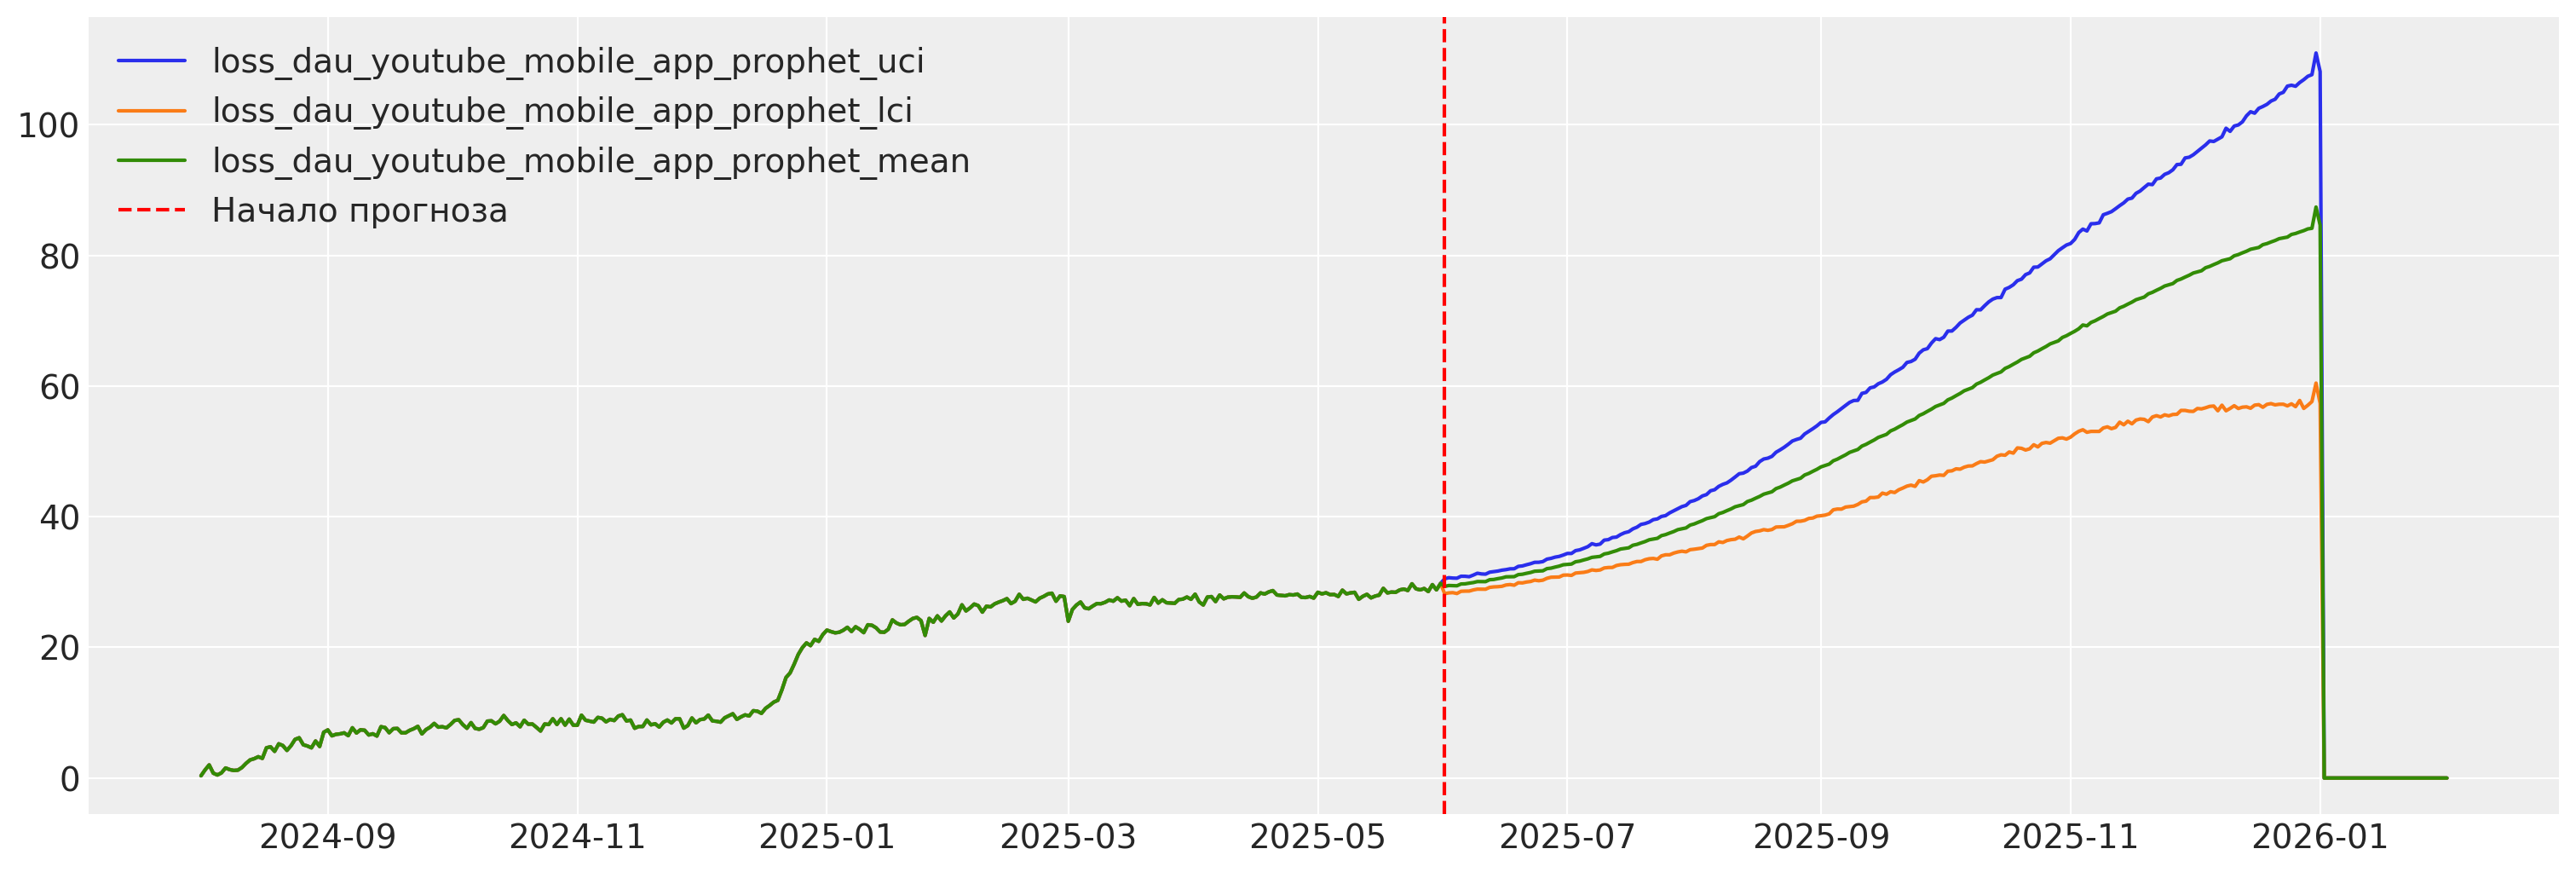

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(df[['loss_dau_youtube_mobile_app_prophet_uci','loss_dau_youtube_mobile_app_prophet_lci','loss_dau_youtube_mobile_app_prophet_mean']].loc[date_start_dau_youtube:])
plt.axvline(x=np.datetime64(date_forecast), color='red', linestyle='--', label='Начало прогноза')
plt.legend(['loss_dau_youtube_mobile_app_prophet_uci','loss_dau_youtube_mobile_app_prophet_lci','loss_dau_youtube_mobile_app_prophet_mean','Начало прогноза'])
plt.grid(True)
plt.show()

### SBA SAA

In [15]:
kpi = 'ba_spontaneous_roll_kpi_percent_14_54_saa'

df['media_360_total_flight_4_ots_shift_1_week'] = df.media_360_total_flight_4_ots.shift(7)
df['media_360_shows_total_ots_flight_5_shift_1_week'] = df.media_360_shows_total_ots_flight_5.shift(7)
df['media_360_shows_for_sba_shift_1_week'] = df.media_360_shows_for_sba.shift(7)
df['const'] = 1.
df.fillna(0,inplace=True)
factors = [
            'const',
            # 'media_360_shows_total_flights_3_4_ots',
            # 'media_360_shows_5_flight_shift_10_days',
            # 'media_360_total_flight_3_ots_shift_10_days',
            # 'media_360_total_flight_4_ots_shift_10_days',
            # 'media_360_shows_total_flights_3_4_ots_shift_10_days',
            # 'media_360_shows_total_ots_flight_5_shift_1_week',
            'media_360_shows_for_sba',
            # 'mqp_bloggers_tvt_30s_hours',
            # 'media_360_shows_for_sba_shift_1_week',
            'mi_vk_fest_ots',
            # 'media_360_total_flight_3_ots_shift_3_weeks_lt',
            # 'media_360_total_flight_4_ots_shift_1_week',
            # 'media_360_total_flight_4_ots_lt',
            'project_smm_ots',
            'loss_dau_youtube_mobile_app_prophet_uci',
            # 'project_pr_ots',
            # 'sba_lag7',
            # 'sba_lag14',
            # 'media_360_shows_shift_23_days',
          ]
date_start_sba = df[~df[kpi].eq(0)].index.min()
date_last_sba = df[~df[kpi].eq(0)].index.max()


y_train = df.loc['2023-09-01':date_last_sba,kpi] # date_start_sba
X_train = df.loc['2023-09-01':date_last_sba,factors] # date_start_sba

date_forecast = date_last_sba + timedelta(days=1)
y_future = df.loc[date_forecast:,kpi]
X_future = df.loc[date_forecast:,factors]

model_sba = sm.OLS(y_train, X_train, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model_sba.summary())

# Predict
y_pred_future = model_sba.predict(X_future)
impact_media_5_flight = model_sba.params.media_360_shows_for_sba*X_train.media_360_shows_for_sba
sba_wo_media = y_train - np.where(impact_media_5_flight.index <= '2024-08-01',0, impact_media_5_flight)
df['sba_wo_media'] = sba_wo_media
df['sba_wo_media'].fillna(0,inplace=True)

y_pred_train = model_sba.fittedvalues
print('SMAPE on train: ', round(SMAPE(y_train, y_pred_train), 2), '%')

                                        OLS Regression Results                                       
Dep. Variable:     ba_spontaneous_roll_kpi_percent_14_54_saa   R-squared:                       0.913
Model:                                                   OLS   Adj. R-squared:                  0.912
Method:                                        Least Squares   F-statistic:                     768.1
Date:                                       Wed, 04 Jun 2025   Prob (F-statistic):          4.29e-233
Time:                                               11:48:33   Log-Likelihood:                 1550.1
No. Observations:                                        599   AIC:                            -3090.
Df Residuals:                                            594   BIC:                            -3068.
Df Model:                                                  4                                         
Covariance Type:                                         HAC                      

11:48:34 - cmdstanpy - INFO - Chain [1] start processing
11:48:34 - cmdstanpy - INFO - Chain [1] done processing
/Users/i.nuriev/Library/Caches/pypoetry/virtualenvs/mmm-tools-9U9JP_nD-py3.11/lib/python3.11/site-packages/prophet/plot.py:94: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


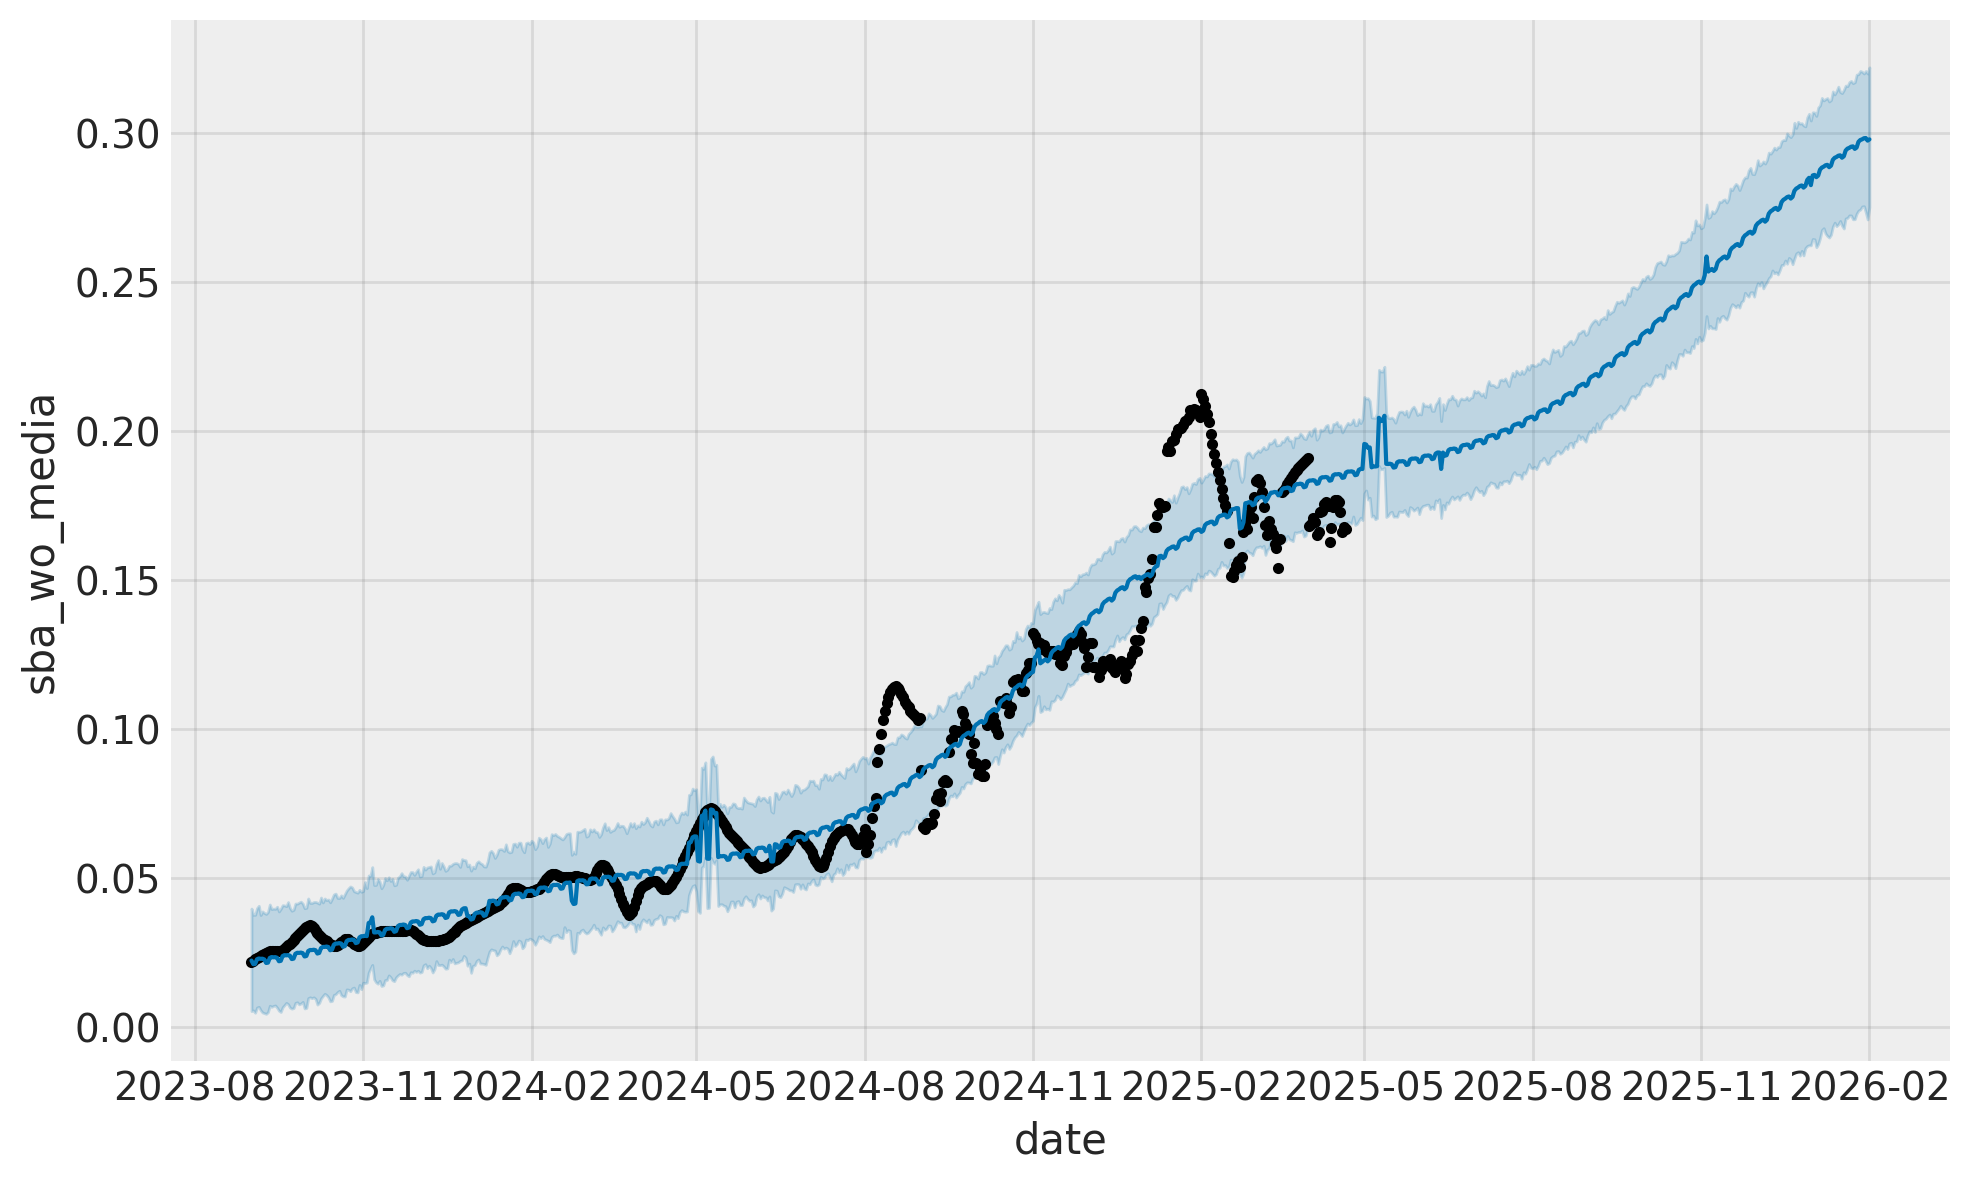

In [16]:
kpi = 'sba_wo_media'
# kpi = 'ba_spontaneous_roll_kpi_percent_14_44'
date_start_sba = df[~df[kpi].eq(0)].index.min()
date_last_sba = df[~df[kpi].eq(0)].index.max()

model = Prophet(growth='linear',
            seasonality_mode='additive', 
            weekly_seasonality=True,
            holidays=holidays,
            yearly_seasonality=1, # 2 гармоники 
            seasonality_prior_scale=30)

data = df.loc[date_start_sba:date_last_sba,].reset_index().rename(columns = {kpi: 'y', 'date': 'ds'})

model.fit(data)

date_diff = (pd.to_datetime('2026-02-01') - date_last_sba).days

future = model.make_future_dataframe(periods=date_diff)

# future['cap'] = trend(horizont)

forecast = model.predict(future)

# Визуализация результатов
fig = model.plot(forecast,ylabel=kpi,xlabel='date')
forecast.index = forecast.ds

In [17]:
date_forecast =  df[~df[kpi].eq(0)].index.max() + timedelta(days=1)
df['sba_prophet_mean_wo_media'] = pd.concat([df.loc[date_start_sba:date_last_sba,kpi],forecast['yhat'].loc[date_forecast:]])
df['sba_prophet_uci_wo_media'] = pd.concat([df.loc[date_start_sba:date_last_sba,kpi],forecast['yhat_upper'].loc[date_forecast:]])
df['sba_prophet_lci_wo_media'] = pd.concat([df.loc[date_start_sba:date_last_sba,kpi],forecast['yhat_lower'].loc[date_forecast:]])

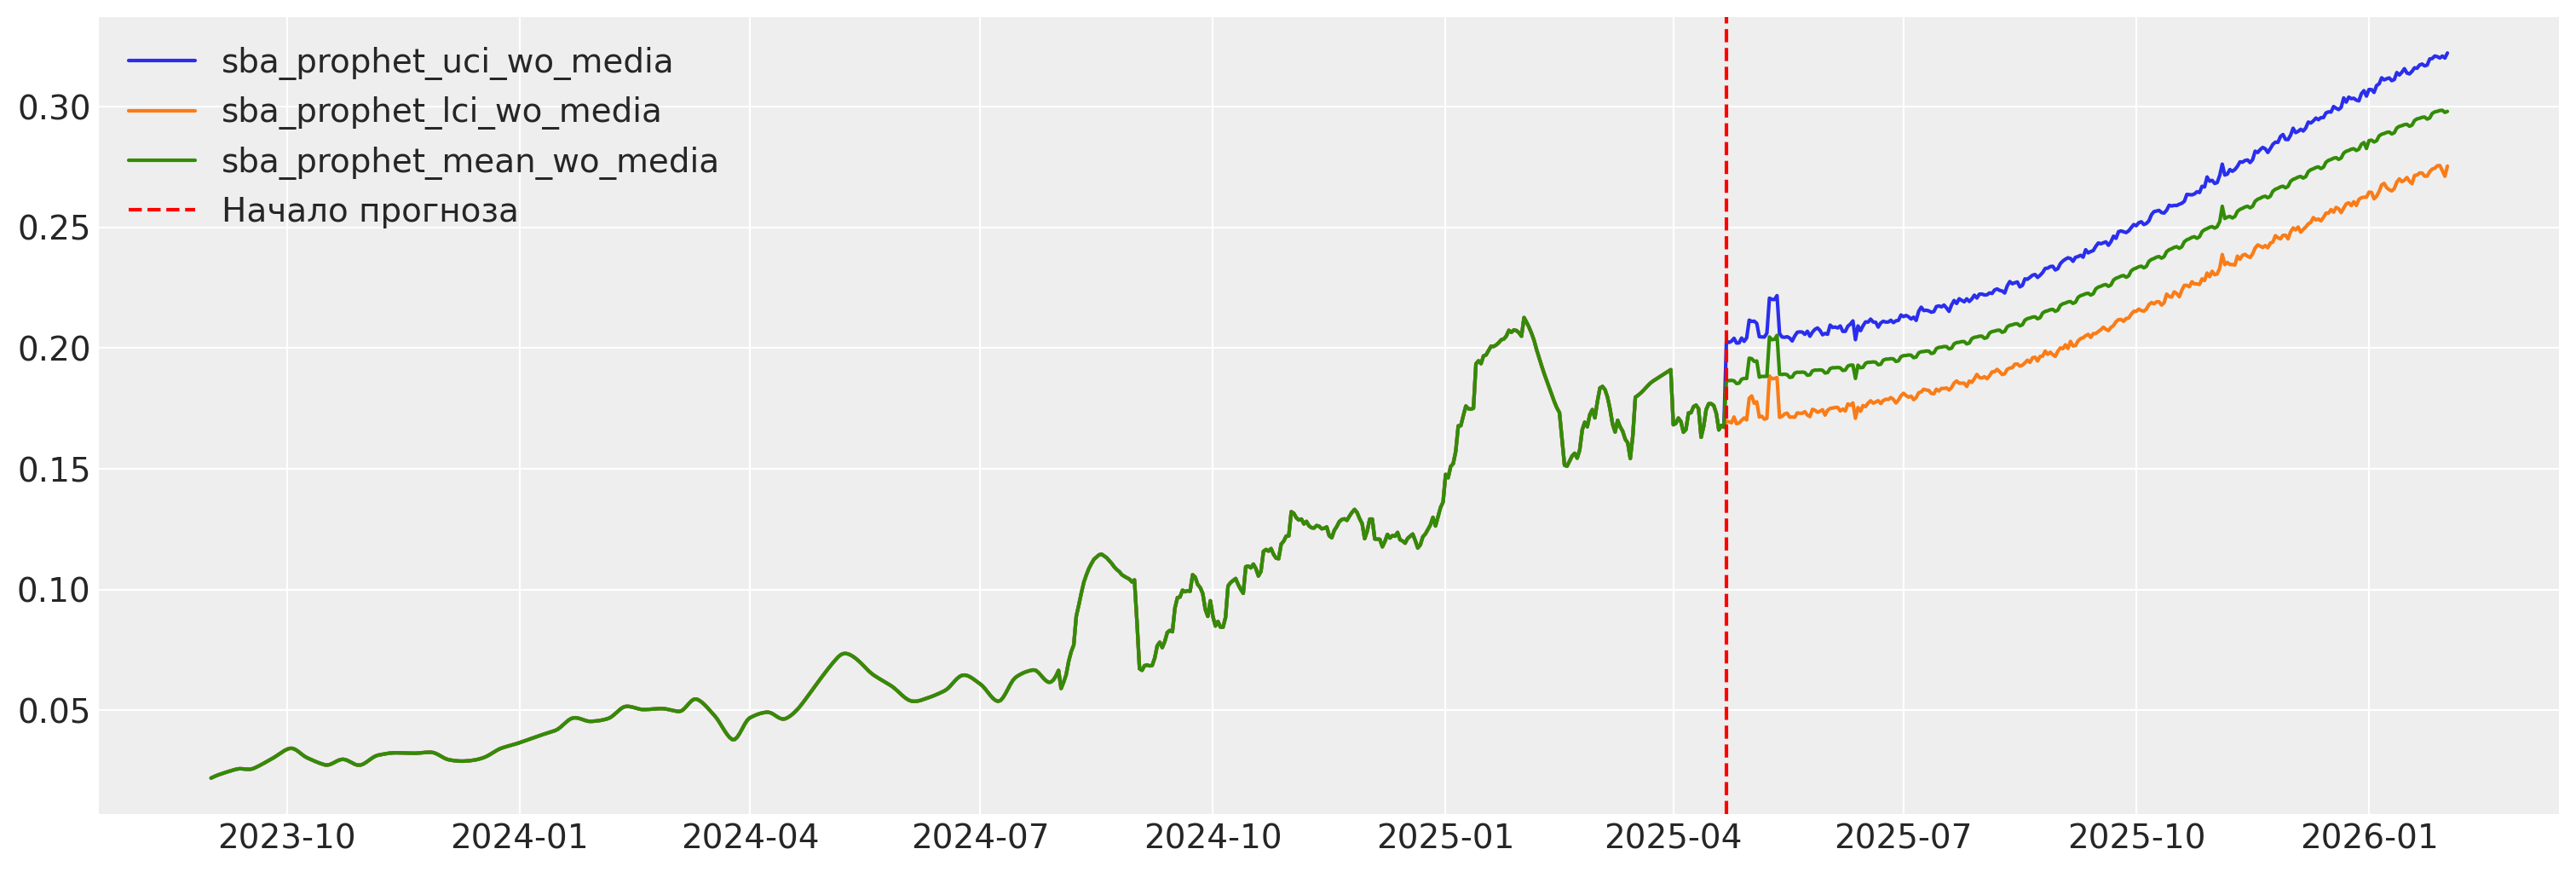

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(df[['sba_prophet_uci_wo_media','sba_prophet_lci_wo_media','sba_prophet_mean_wo_media']])
plt.axvline(x=np.datetime64(date_forecast), color='red', linestyle='--', label='Начало прогноза')
plt.legend(['sba_prophet_uci_wo_media','sba_prophet_lci_wo_media','sba_prophet_mean_wo_media','Начало прогноза'])
plt.grid(True)
plt.show()

### Other control variables

In [19]:
df['dummy_october'] = 0.
df.loc['2024-10-01': ,'dummy_october'] = 1.

df['competitors_tv_total_ots'] = df[['rutube_tv_ots', 'okko_tv_ots']].sum(axis=1)

## Target Variable

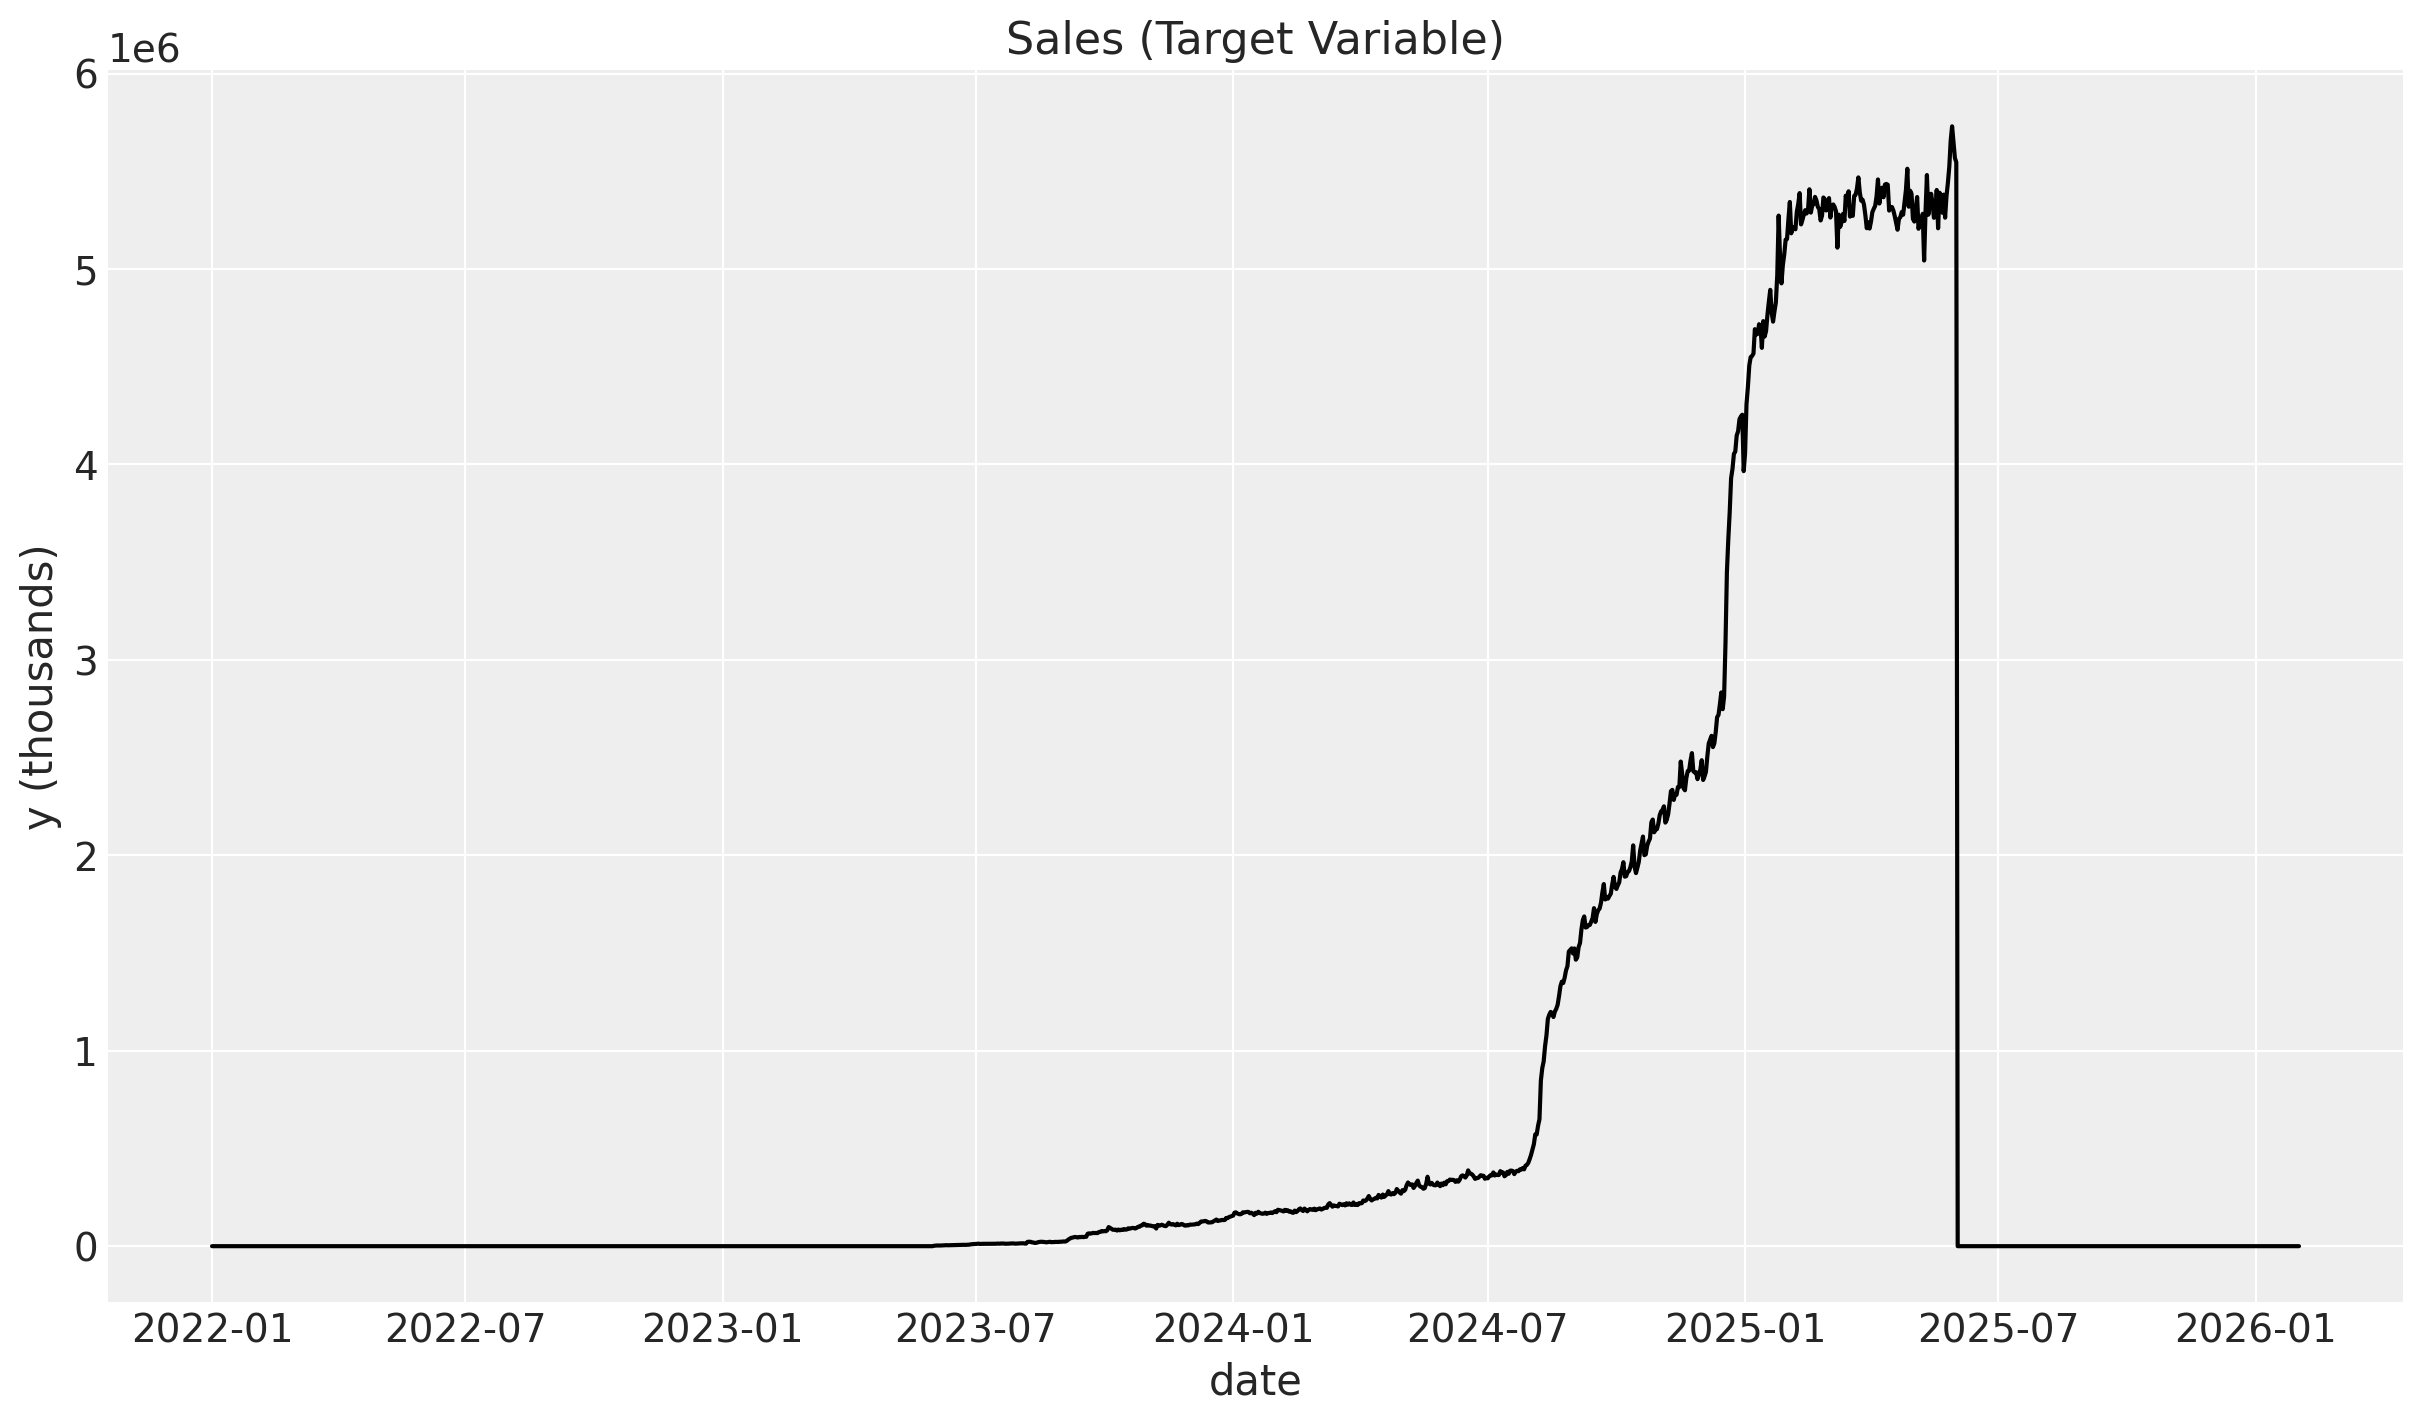

In [20]:
df["y"] = df['dau_saa']

fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

## Part II: Modeling

### 1. Feature Engineering

In [21]:
# # trend feature
# df["t"] = range(n)

# data.head()

### 2. Model Specification

Поскольку мы не знаем многого о каналах, мы начнем с простой эвристики:

Вклады каналов должны быть положительными, поэтому мы можем, например, использовать полунормальное распределение в качестве априорного распределения. Нам нужно задать параметр sigma для каждого канала. Чем выше сигма, тем больше «свободы» для подгонки данных. Для задания сигмы можно воспользоваться следующим моментом.
Мы ожидаем, что каналы, на которые мы тратим больше всего, будут иметь больше вклад в DAU, прежде чем увидим данные. Это очень разумное предположение (заметьте, мы ничего не навязываем на уровне эффективности!).

In [53]:
date_flight_start = '2025-04-01'
date_flight_end = '2025-05-04'
# total_spend_per_channel = df[["tv_nat_spends", "ooh_spends",'digital_media_total_spends']].loc[date_flight_start:date_flight_end].sum(axis=0)
# total_spend_per_channel = df[["tv", "ooh",'digital_media']].loc[date_flight_start:date_flight_end].sum(axis=0)

# spend_share = round(total_spend_per_channel / total_spend_per_channel.sum(),2)
spend_share = [317/550, 124/550, 109/550]
spend_share

[0.5763636363636364, 0.22545454545454546, 0.19818181818181818]

In [54]:
n_channels = 3

prior_sigma = n_channels * np.array(spend_share)#.to_numpy()

prior_sigma.tolist()

[1.7290909090909092, 0.6763636363636364, 0.5945454545454545]

In [24]:
df['y'] = df['dau_saa']
X = df[[
        # 'dummy_october',
        'loss_dau_youtube_mobile_app_prophet_lci',
        # 'competitors_tv_total_ots',
        'sba_prophet_mean_wo_media',
        'tv',
        'ooh',
        'digital_media']].loc['2024-08-01':'2025-05-04'].reset_index()
y = df["y"].loc['2024-08-01':'2025-05-04']

Вы можете использовать необязательный параметр 'model_config', чтобы применить к модели свои собственные априорные оценки. Каждая запись в 'model_config' содержит ключ, который соответствует имени зарегистрированного распределения в нашей модели. Значение ключа - это словарь, описывающий входные параметры этого конкретного распределения.

Если вы не знаете, как определить собственные приорные параметры, вы можете воспользоваться свойством 'default_model_config' в МММ, чтобы увидеть требуемую структуру.

In [25]:
dummy_model = MMM(
    date_column="",
    channel_columns=[""],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
)
dummy_model.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [26]:
# Порядок: tv, ooh, digital
alpha_adstock=[1.2, 0.7, 1]  # Форма (ближе к 1 = равномернее)
beta_adstock=[3, 3, 3] # Форма (больше = смещение к 0)

alpha_saturation=[4, 2, 3] # Форма (выше = резче насыщение)
beta_saturation=[1.5, 1.5, 1]  # Масштаб (обратный интенсивности)

my_model_config = {
    "intercept": {"dist": "Normal", "kwargs": {"mu": 0, "sigma": 1}},
    "saturation_beta": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": prior_sigma},
    },
    "gamma_control": {
        "dist": "Normal",
        "kwargs": {
            "mu": 0,
            "sigma": 1
        }
    },
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": {"mu": 0, "b": 1},
    },
    "adstock_alpha": {
        "dist": "Beta",
        "kwargs": {"alpha": alpha_adstock, "beta": beta_adstock},
    },
    "saturation_lam": {
        "dist": "Gamma",
        "kwargs": {"alpha": alpha_saturation, "beta": beta_saturation},
    },    
"likelihood": {
    "dist": "Normal",  # Нормальное распределение ошибок
    "kwargs": {
        "sigma": {  # Стандартное отклонение ошибок
            "dist": "Exponential",  # Экспоненциальное распределение для sigma
            "kwargs": {"lam": 1 / 10}  # Параметр lambda = 0.1
        }
    }
}
}

In [27]:
my_sampler_config = {
    "draws": 5000,
    "tune": 5000,
    "chains": 4,
    "target_accept": 0.90,
    "progressbar": True
}   

In [28]:
mmm = MMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column="date",
    adstock=GeometricAdstock(l_max=14),
    saturation=LogisticSaturation(),
    channel_columns=["tv", "ooh",'digital_media'],
    control_columns=[
        'loss_dau_youtube_mobile_app_prophet_lci',
        # 'competitors_tv_total_ots',
        'sba_prophet_mean_wo_media'
    ],
    yearly_seasonality=2,
)

In [29]:
X.fillna(0,inplace=True)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept, saturation_beta, saturation_lam, y, y_sigma]


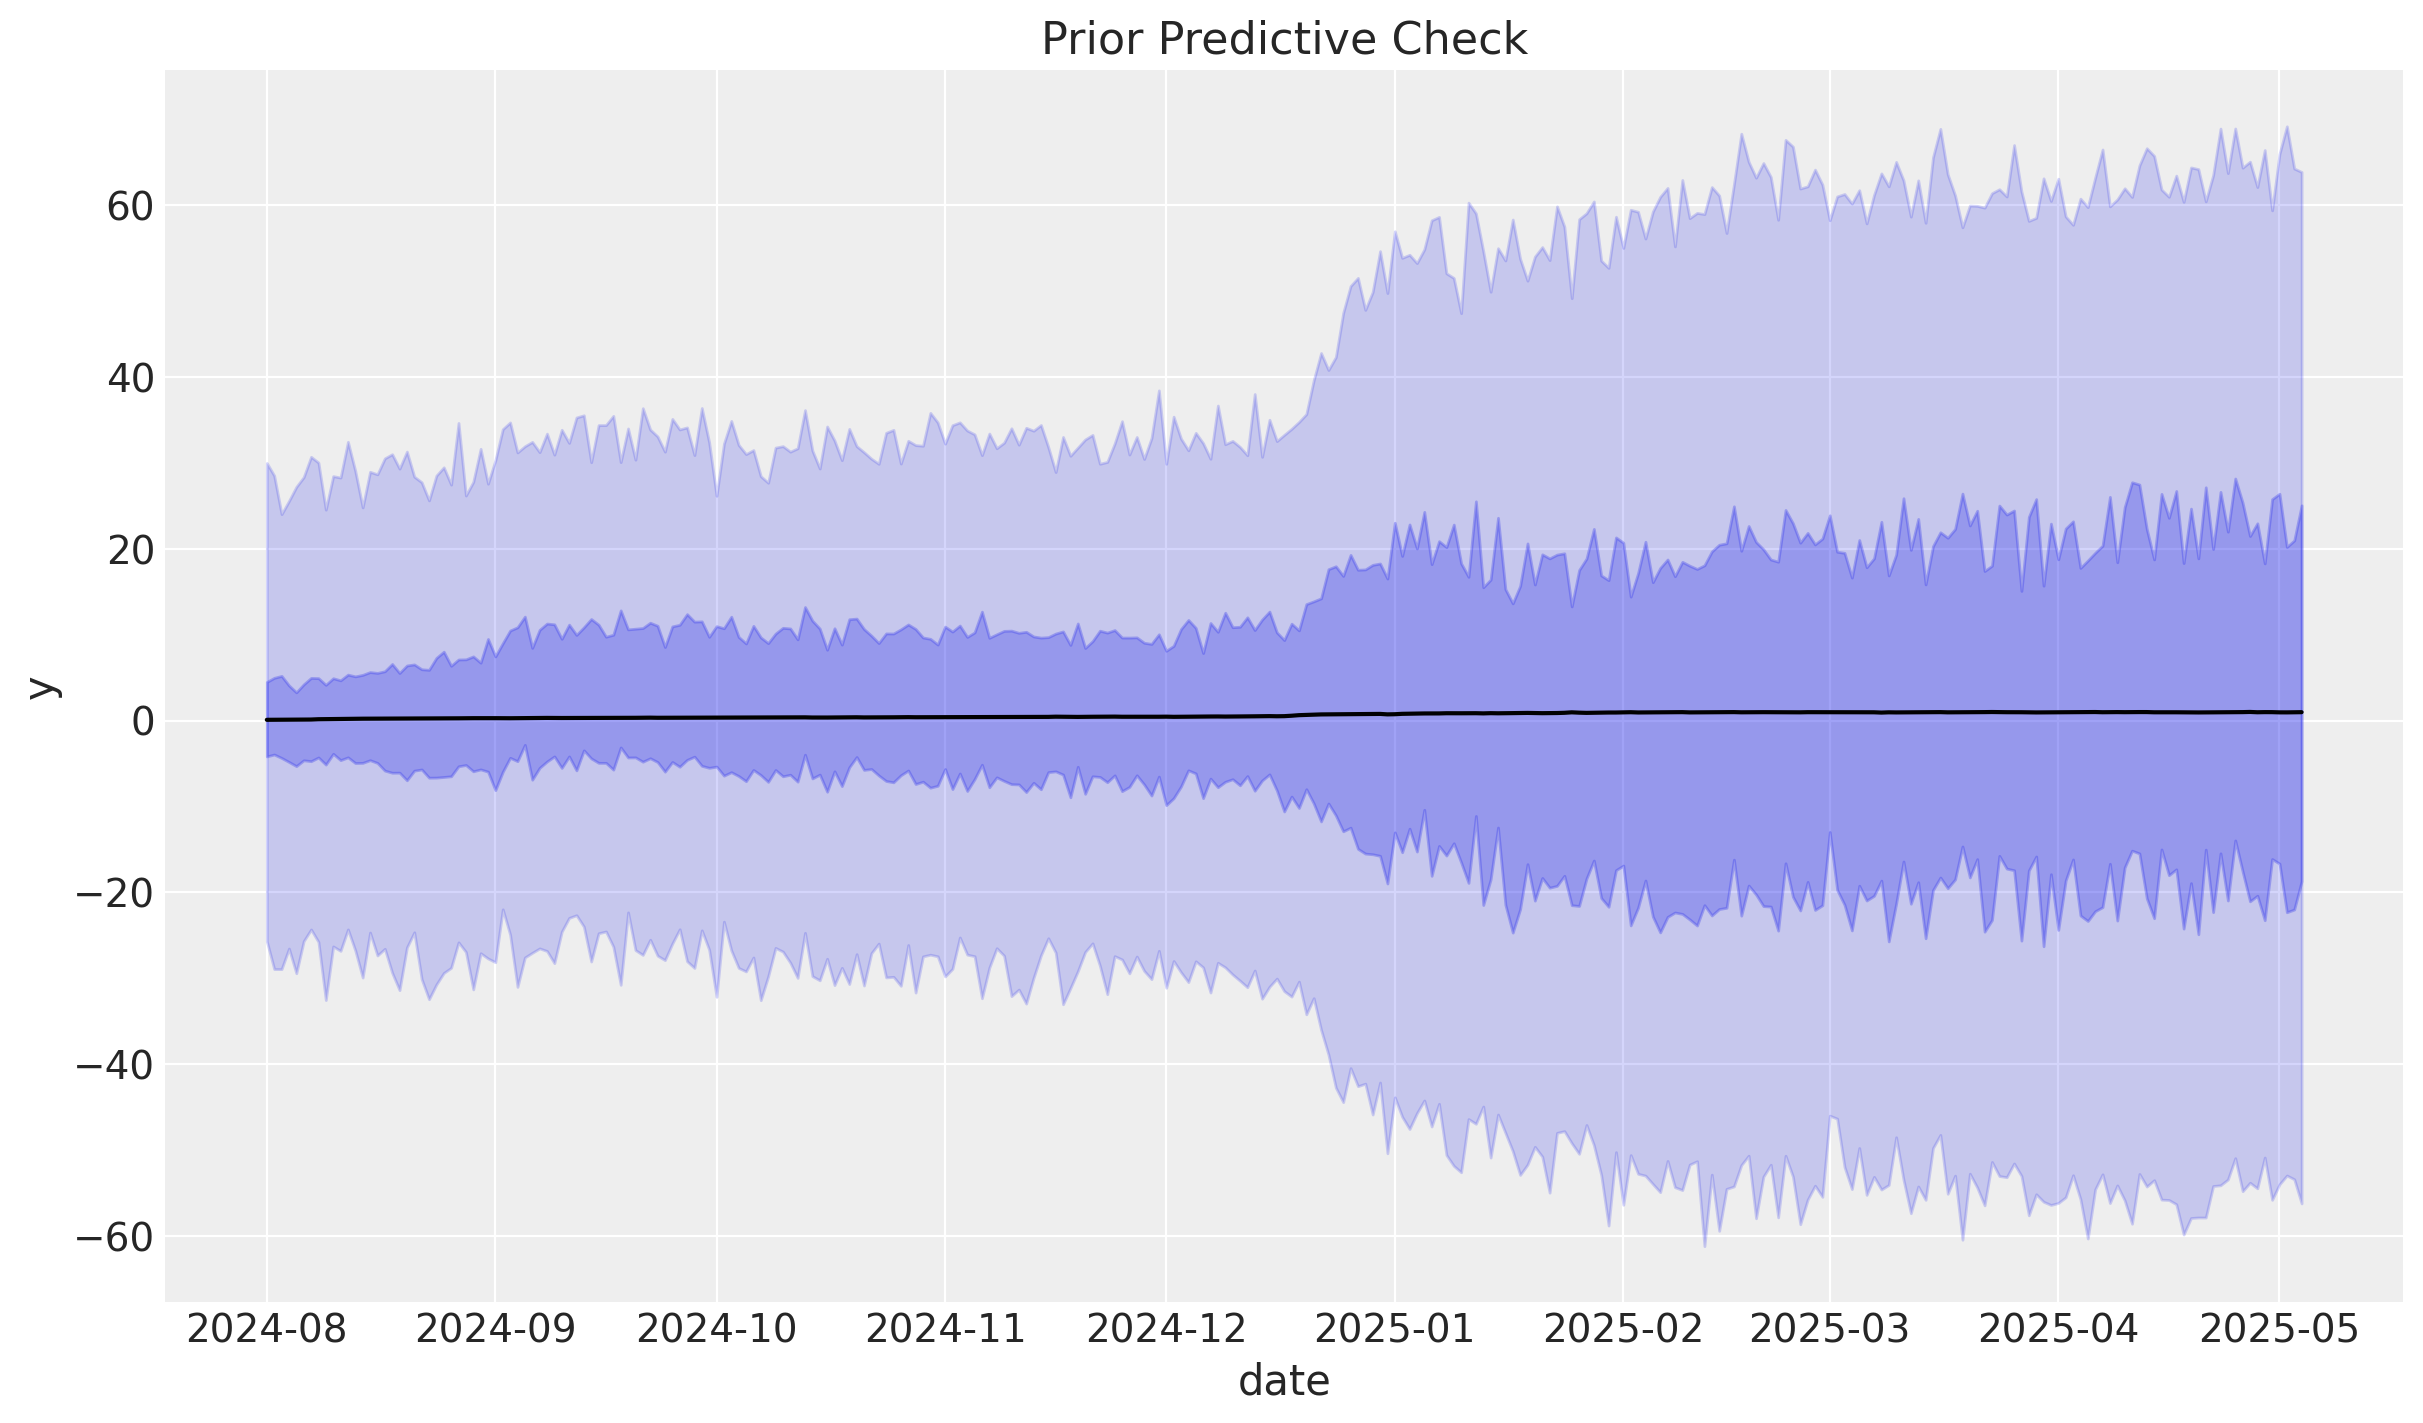

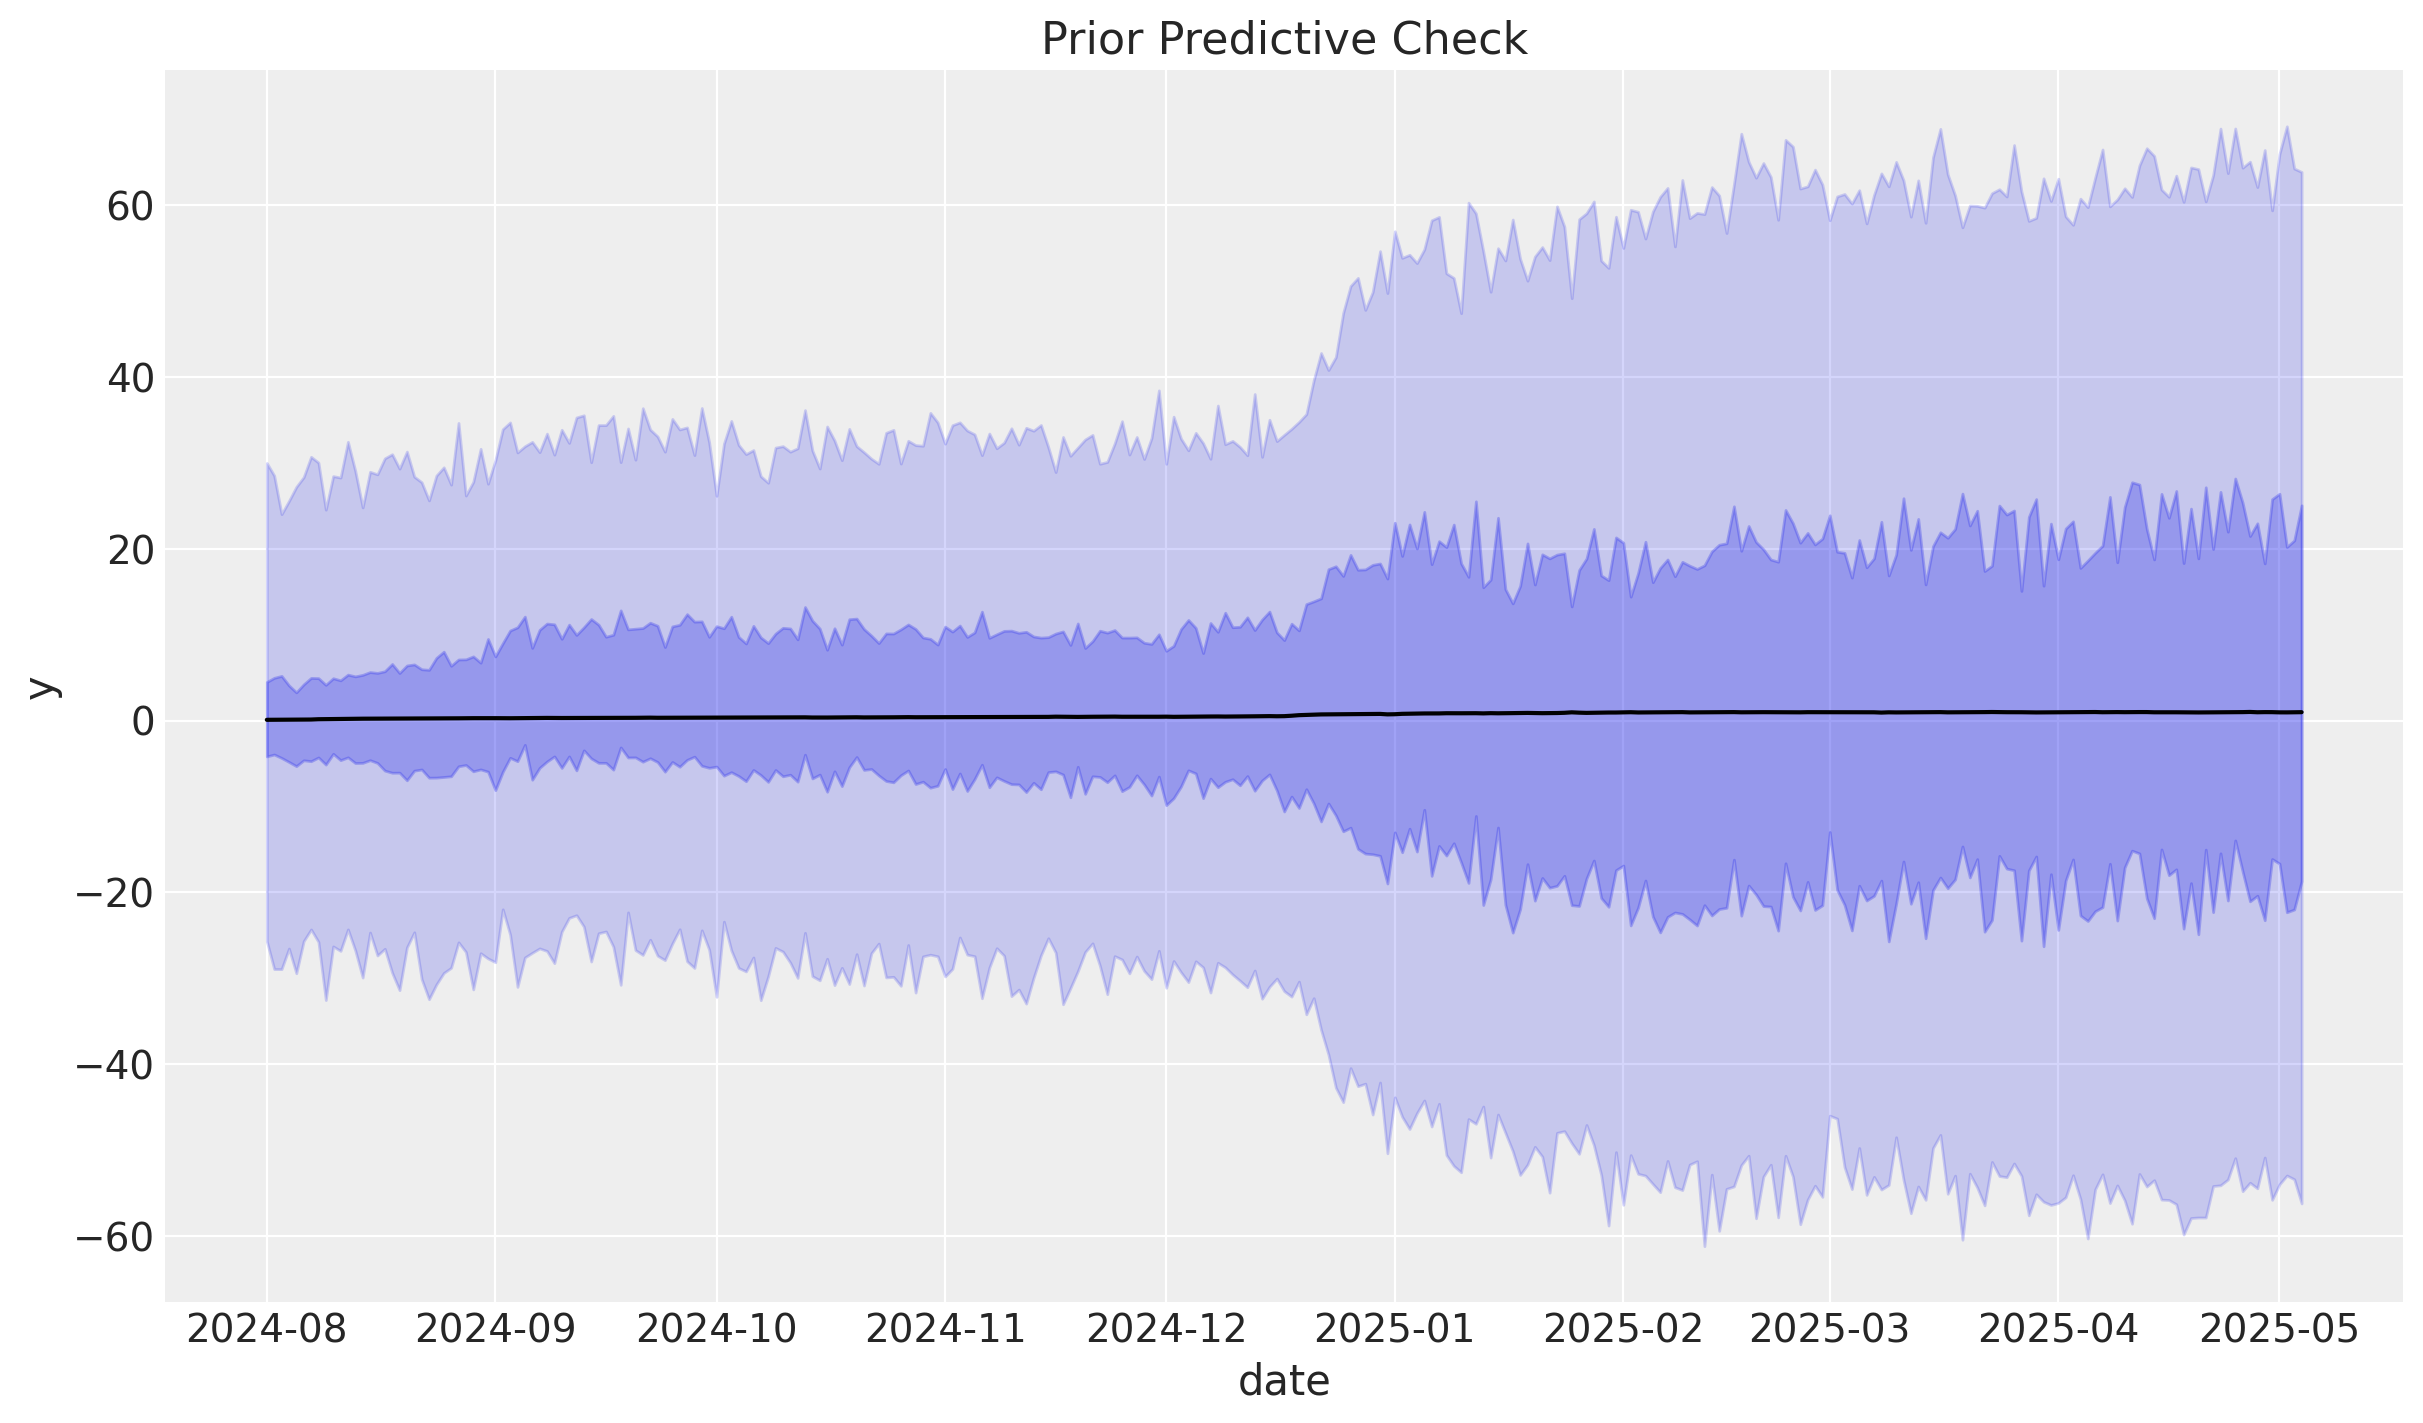

In [30]:
# Generate prior predictive samples
mmm.sample_prior_predictive(X, y, samples=2_000)

mmm.plot_prior_predictive()

In [31]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [32]:
mmm.fit(X=X, y=y, target_accept=0.85, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 144 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

In [33]:
type(mmm.model)

pymc.model.core.Model

In [34]:
print(f"Model was train using the {mmm.saturation.__class__.__name__} function")
print(f"and the {mmm.adstock.__class__.__name__} function")

Model was train using the LogisticSaturation function
and the GeometricAdstock function


### Model Diagnostic

In [35]:
# Number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

0

In [36]:
mmm.fit_result

<xarray.Dataset> Size: 490MB
Dimensions:                          (chain: 4, draw: 5000, control: 2,
                                      fourier_mode: 4, channel: 3, date: 277)
Coordinates:
  * chain                            (chain) int64 32B 0 1 2 3
  * draw                             (draw) int64 40kB 0 1 2 ... 4997 4998 4999
  * control                          (control) <U39 312B 'loss_dau_youtube_mo...
  * fourier_mode                     (fourier_mode) <U5 80B 'sin_1' ... 'cos_2'
  * channel                          (channel) <U13 156B 'tv' ... 'digital_me...
  * date                             (date) datetime64[ns] 2kB 2024-08-01 ......
Data variables:
    intercept                        (chain, draw) float64 160kB 0.1495 ... 0...
    gamma_control                    (chain, draw, control) float64 320kB 0.0...
    gamma_fourier                    (chain, draw, fourier_mode) float64 640kB ...
    adstock_alpha                    (chain, draw, channel) float64 480kB 0.0...
    saturation_lam                   (chain, draw, channel) float64 480kB 1.4...
    saturation_beta                  (chain, draw, channel) float64 480kB 0.0...
    y_sigma                          (chain, draw) float64 160kB 0.02343 ... ...
    channel_contributions            (chain, draw, date, channel) float64 133MB ...
    control_contributions            (chain, draw, date, control) float64 89MB ...
    fourier_contributions            (chain, draw, date, fourier_mode) float64 177MB ...
    yearly_seasonality_contribution  (chain, draw, date) float64 44MB -0.1039...
    mu                               (chain, draw, date) float64 44MB 0.1216 ...
Attributes:
    created_at:                 2025-06-04T08:51:09.756820+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.15.1
    sampling_time:              144.218496799469
    tuning_steps:               5000

In [37]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
    ],
)

mean     sd  hdi_3%  \
intercept                                           0.157  0.014   0.131   
y_sigma                                             0.023  0.001   0.021   
saturation_beta[tv]                                 0.028  0.035   0.000   
saturation_beta[ooh]                                0.281  0.229   0.028   
saturation_beta[digital_media]                      0.047  0.060   0.000   
saturation_lam[tv]                                  1.893  1.081   0.207   
saturation_lam[ooh]                                 0.544  0.380   0.053   
saturation_lam[digital_media]                       1.811  1.268   0.059   
adstock_alpha[tv]                                   0.204  0.163   0.000   
adstock_alpha[ooh]                                  0.305  0.192   0.000   
adstock_alpha[digital_media]                        0.174  0.142   0.000   
gamma_control[loss_dau_youtube_mobile_app_proph...  0.018  0.001   0.017   
gamma_control[sba_prophet_mean_wo_media]            0.978  0.118   0.760   
gamma_fourier[sin_1]                                0.116  0.008   0.101   
gamma_fourier[sin_2]                                0.001  0.002  -0.004   
gamma_fourier[cos_1]                                0.058  0.004   0.050   
gamma_fourier[cos_2]                               -0.005  0.003  -0.011   

                                                    hdi_97%  mcse_mean  \
intercept                                             0.185      0.000   
y_sigma                                               0.025      0.000   
saturation_beta[tv]                                   0.073      0.000   
saturation_beta[ooh]                                  0.713      0.002   
saturation_beta[digital_media]                        0.128      0.001   
saturation_lam[tv]                                    3.841      0.008   
saturation_lam[ooh]                                   1.235      0.004   
saturation_lam[digital_media]                         4.057      0.010   
adstock_alpha[tv]                                     0.512      0.001   
adstock_alpha[ooh]                                    0.607      0.002   
adstock_alpha[digital_media]                          0.437      0.001   
gamma_control[loss_dau_youtube_mobile_app_proph...    0.020      0.000   
gamma_control[sba_prophet_mean_wo_media]              1.206      0.001   
gamma_fourier[sin_1]                                  0.131      0.000   
gamma_fourier[sin_2]                                  0.005      0.000   
gamma_fourier[cos_1]                                  0.067      0.000   
gamma_fourier[cos_2]                                  0.000      0.000   

                                                    mcse_sd  ess_bulk  \
intercept                                             0.000   10975.0   
y_sigma                                               0.000   23267.0   
saturation_beta[tv]                                   0.000   10045.0   
saturation_beta[ooh]                                  0.002    9309.0   
saturation_beta[digital_media]                        0.000    9203.0   
saturation_lam[tv]                                    0.005   16500.0   
saturation_lam[ooh]                                   0.003   10149.0   
saturation_lam[digital_media]                         0.007   11466.0   
adstock_alpha[tv]                                     0.001   20901.0   
adstock_alpha[ooh]                                    0.001   12537.0   
adstock_alpha[digital_media]                          0.001   15758.0   
gamma_control[loss_dau_youtube_mobile_app_proph...    0.000    8844.0   
gamma_control[sba_prophet_mean_wo_media]              0.001    9455.0   
gamma_fourier[sin_1]                                  0.000   10253.0   
gamma_fourier[sin_2]                                  0.000   15707.0   
gamma_fourier[cos_1]                                  0.000   11180.0   
gamma_fourier[cos_2]                                  0.000   12922.0   

                                    

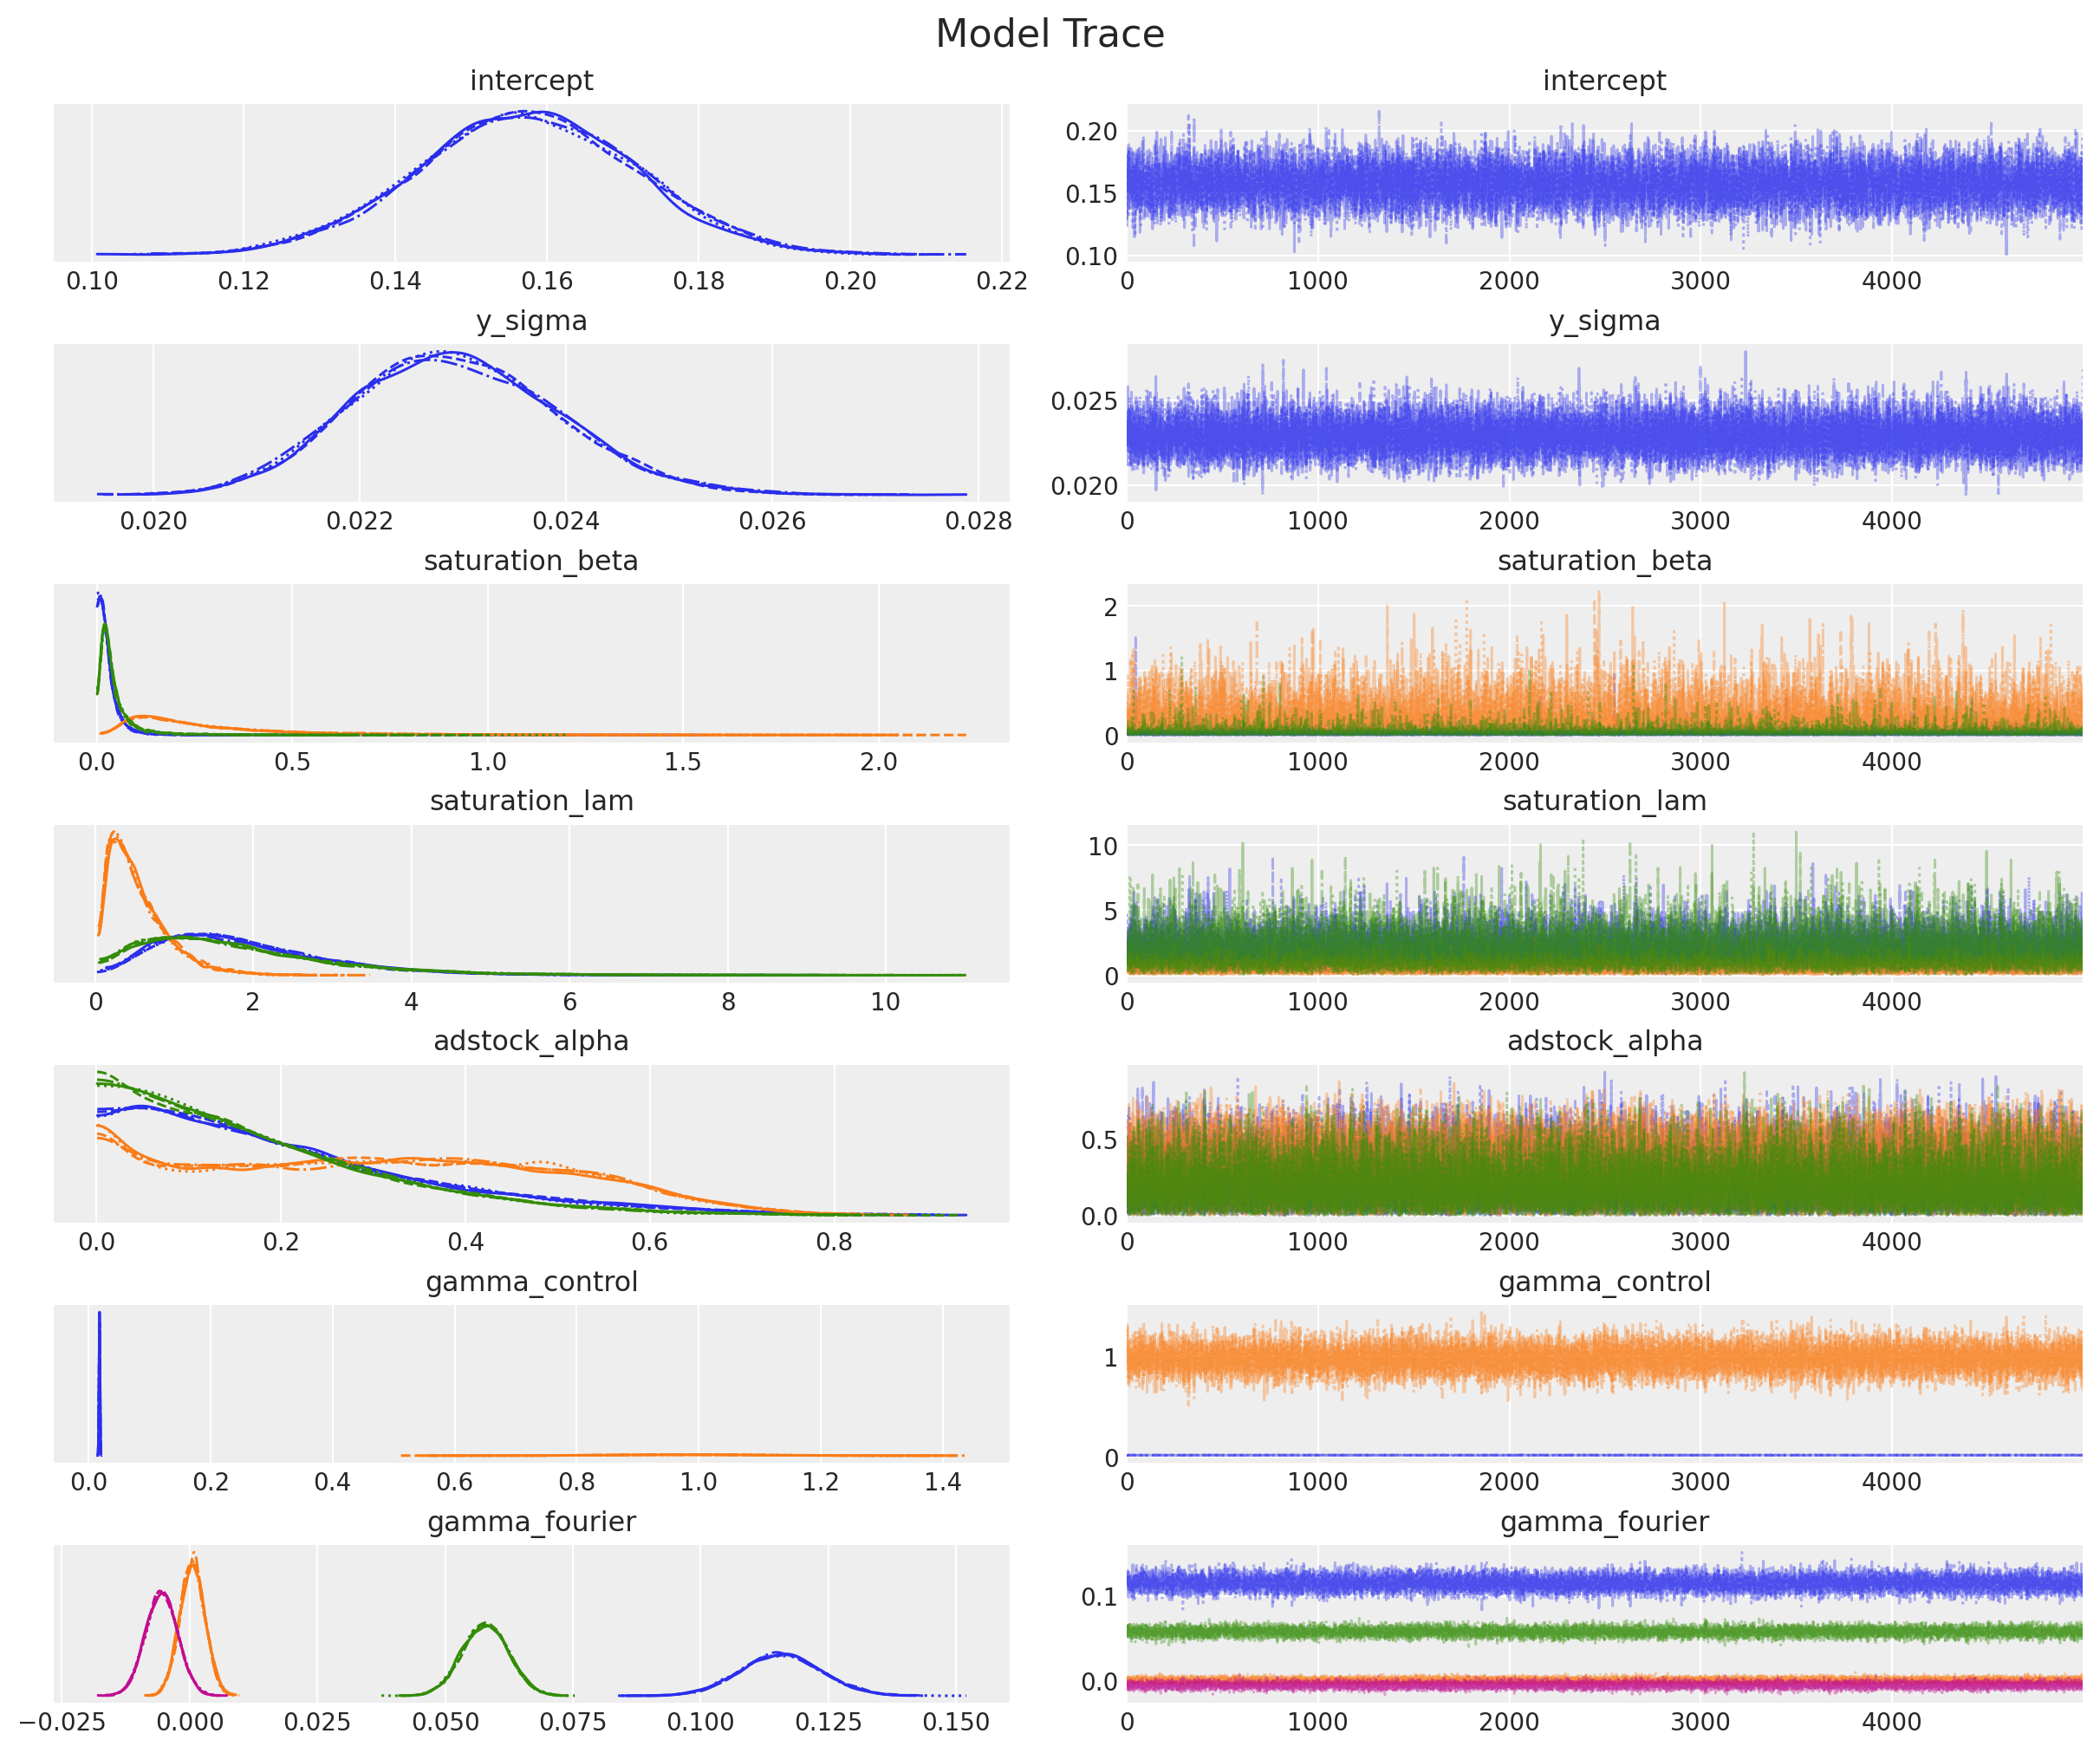

In [38]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [39]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 45MB
Dimensions:  (sample: 20000, date: 277)
Coordinates:
  * date     (date) datetime64[ns] 2kB 2024-08-01 2024-08-02 ... 2025-05-04
  * sample   (sample) object 160kB MultiIndex
  * chain    (sample) int64 160kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 160kB 0 1 2 3 4 5 ... 4994 4995 4996 4997 4998 4999
Data variables:
    y        (date, sample) float64 44MB 4.176e+05 6.296e+05 ... 5.369e+06
Attributes:
    created_at:                 2025-06-04T08:51:13.261520+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.15.1

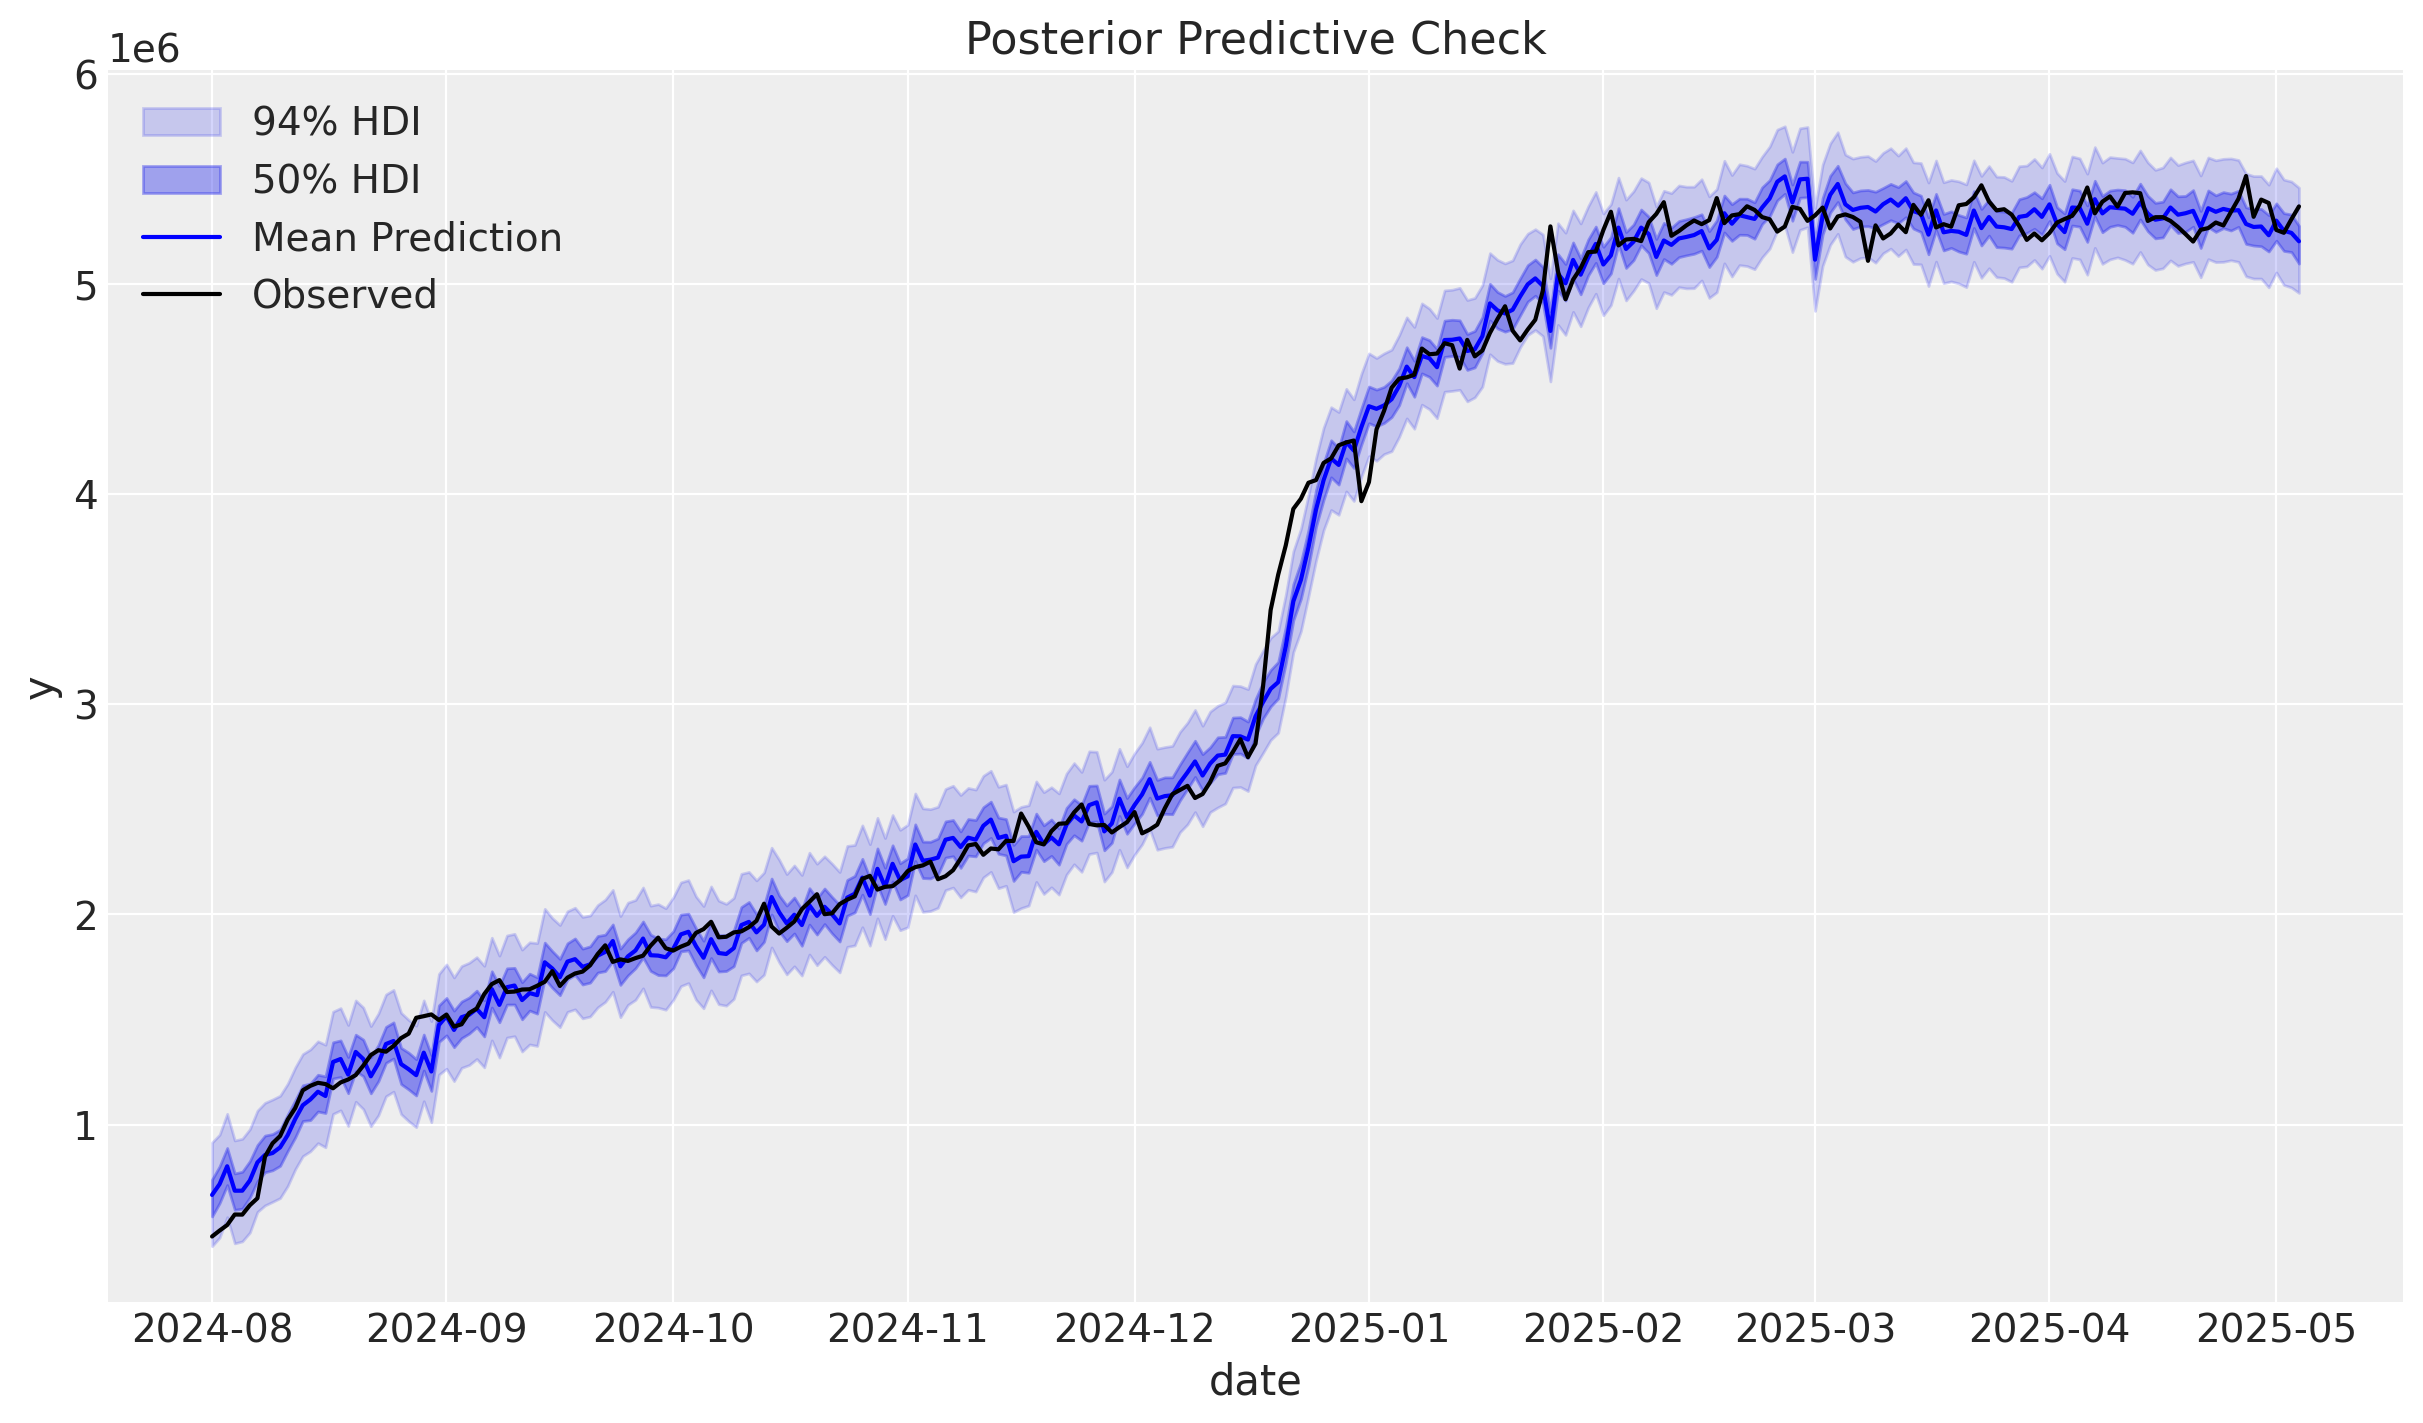

In [40]:
mmm.plot_posterior_predictive(original_scale=True);

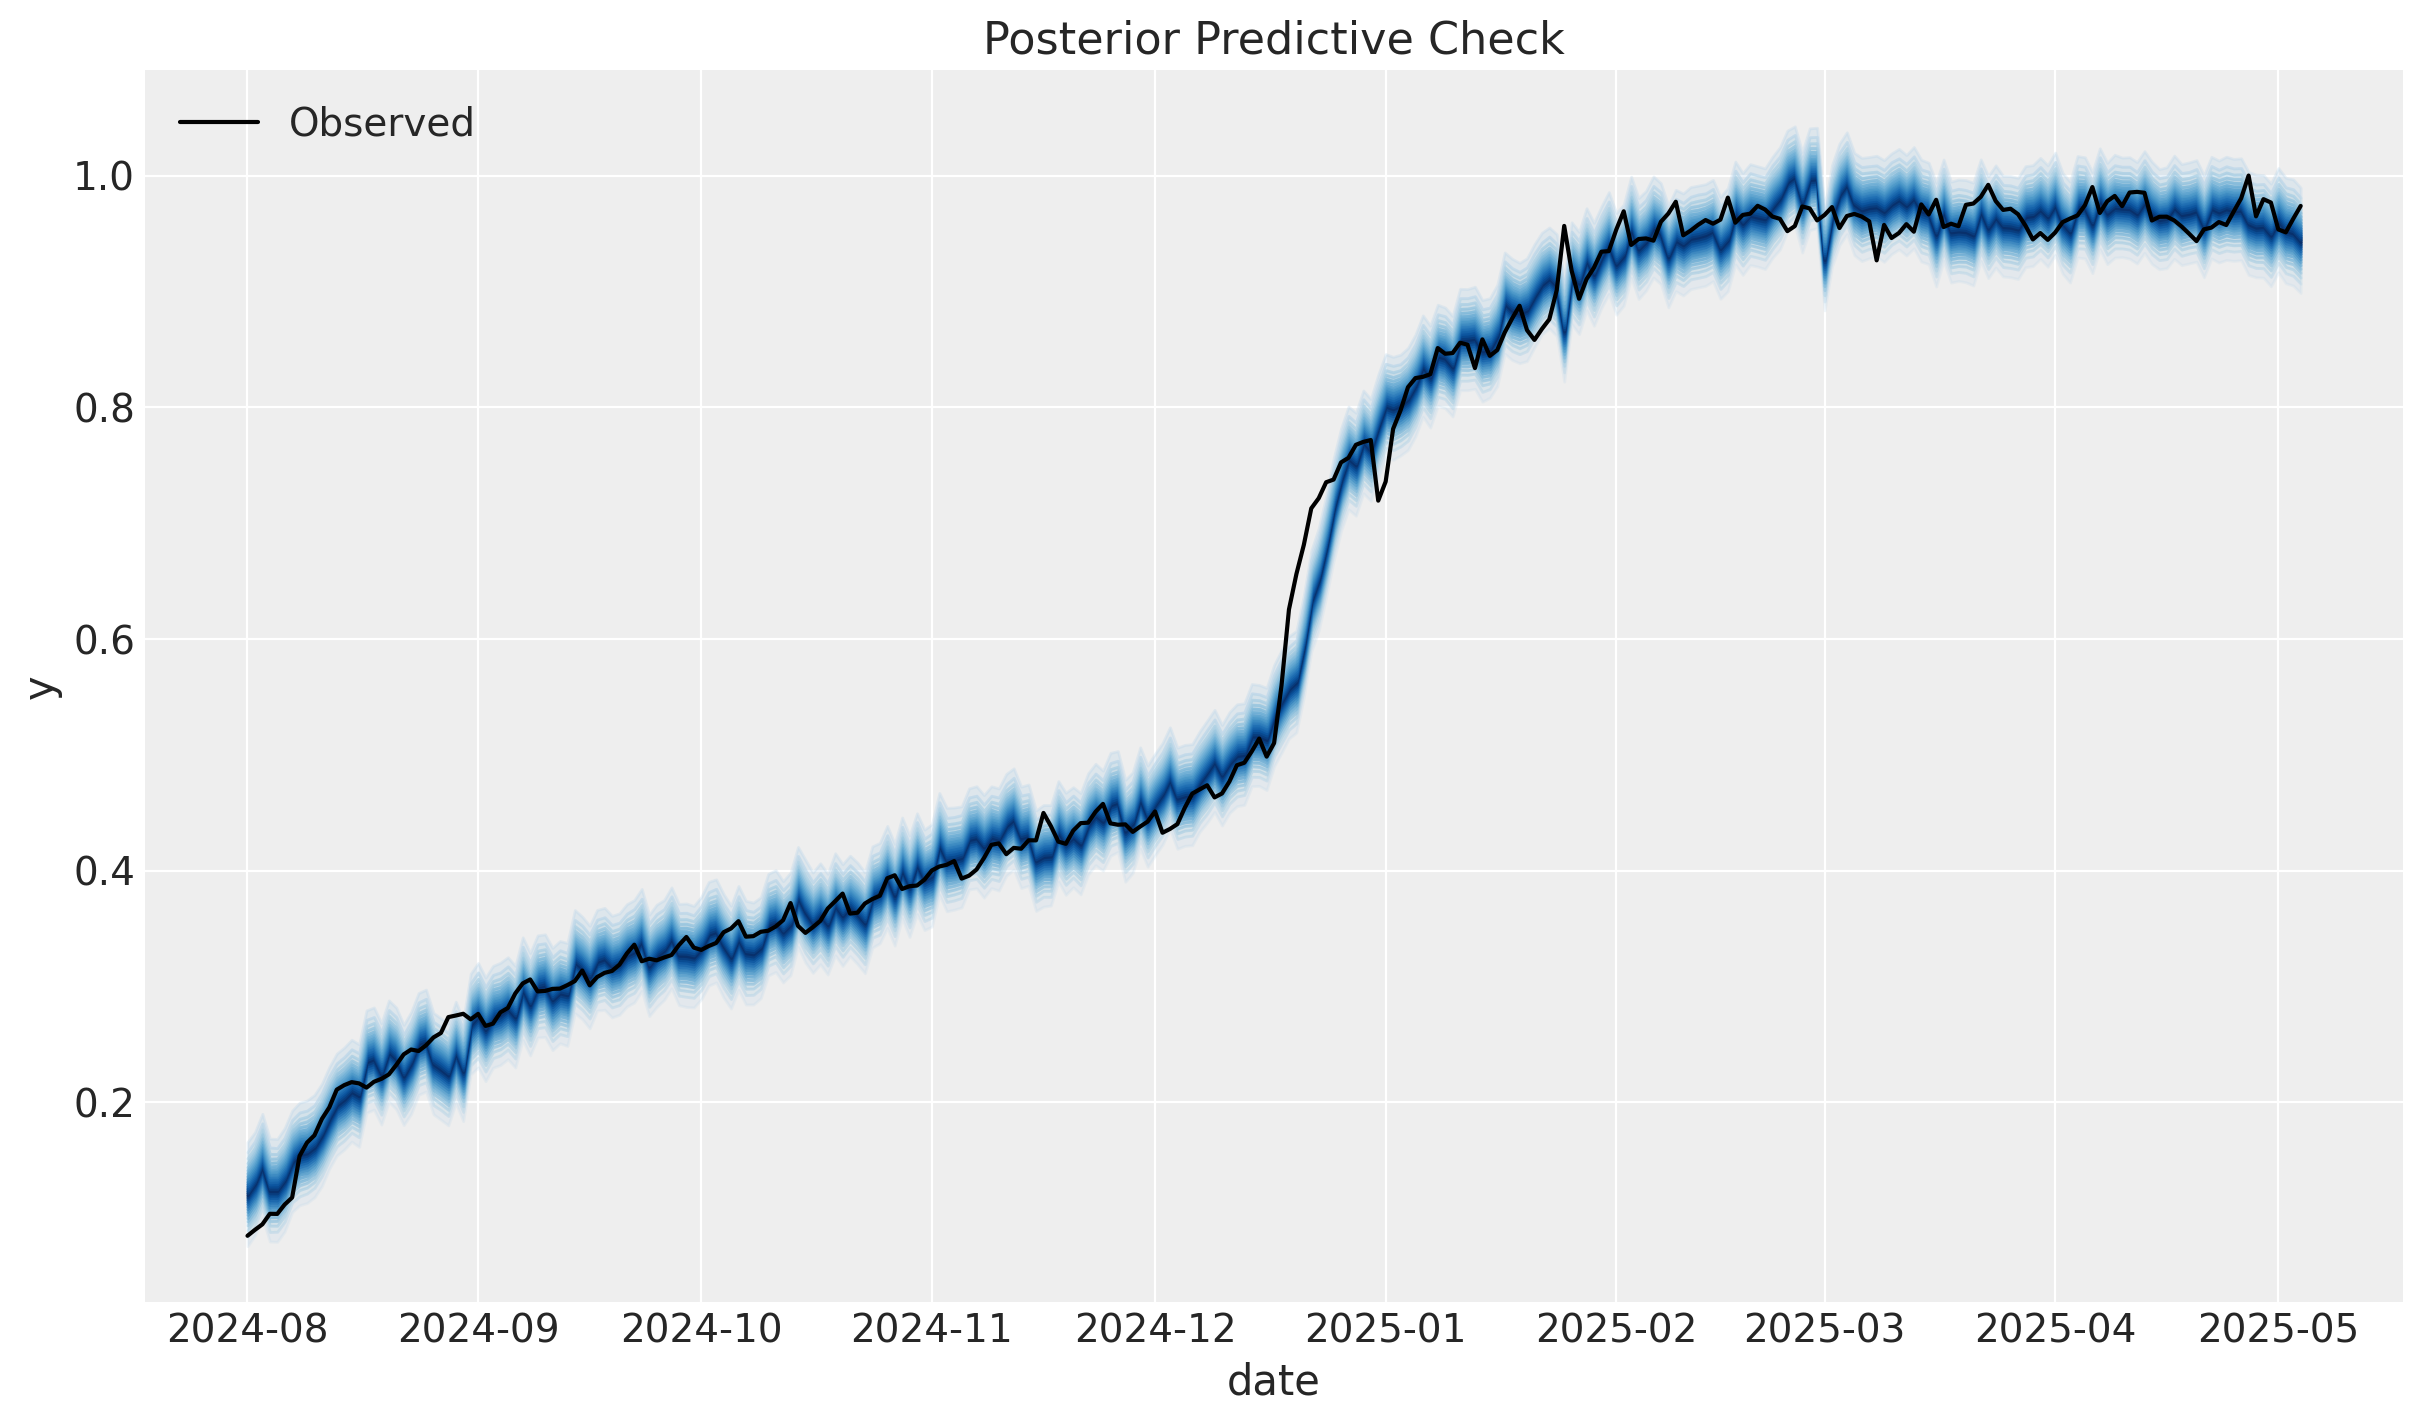

In [41]:
mmm.plot_posterior_predictive(add_hdi=False, add_mean=False, add_gradient=True);

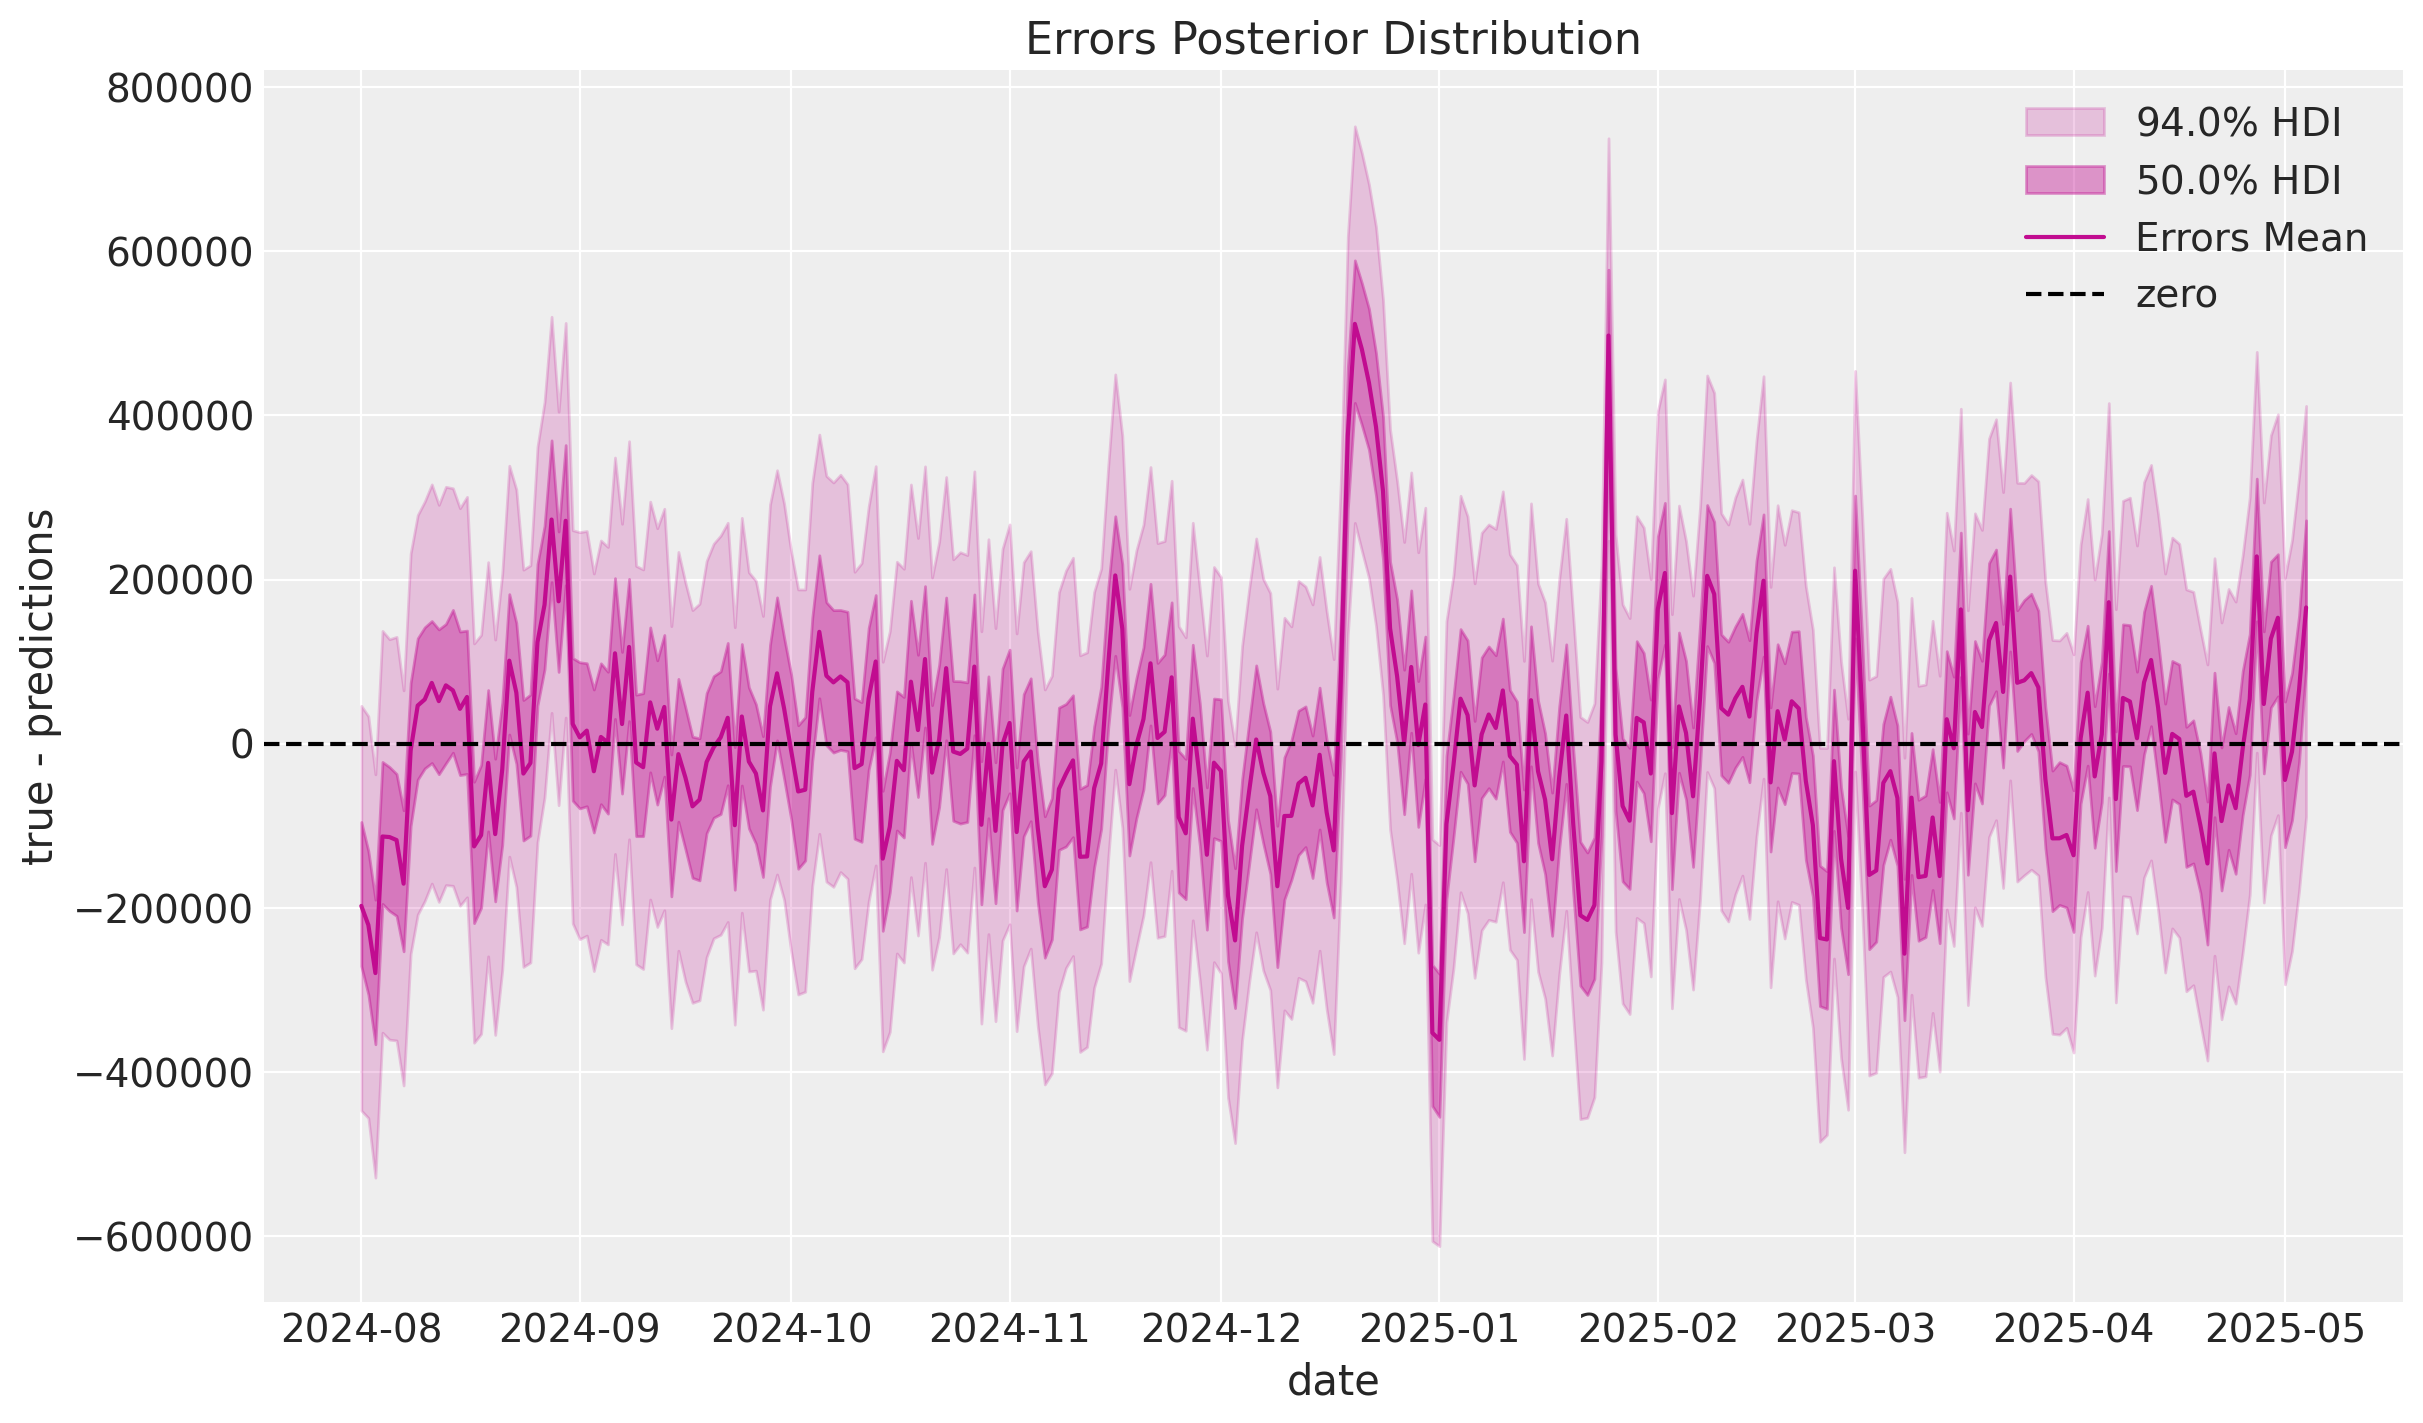

In [42]:
mmm.plot_errors(original_scale=True);

In [43]:
errors = mmm.get_errors(original_scale=True)

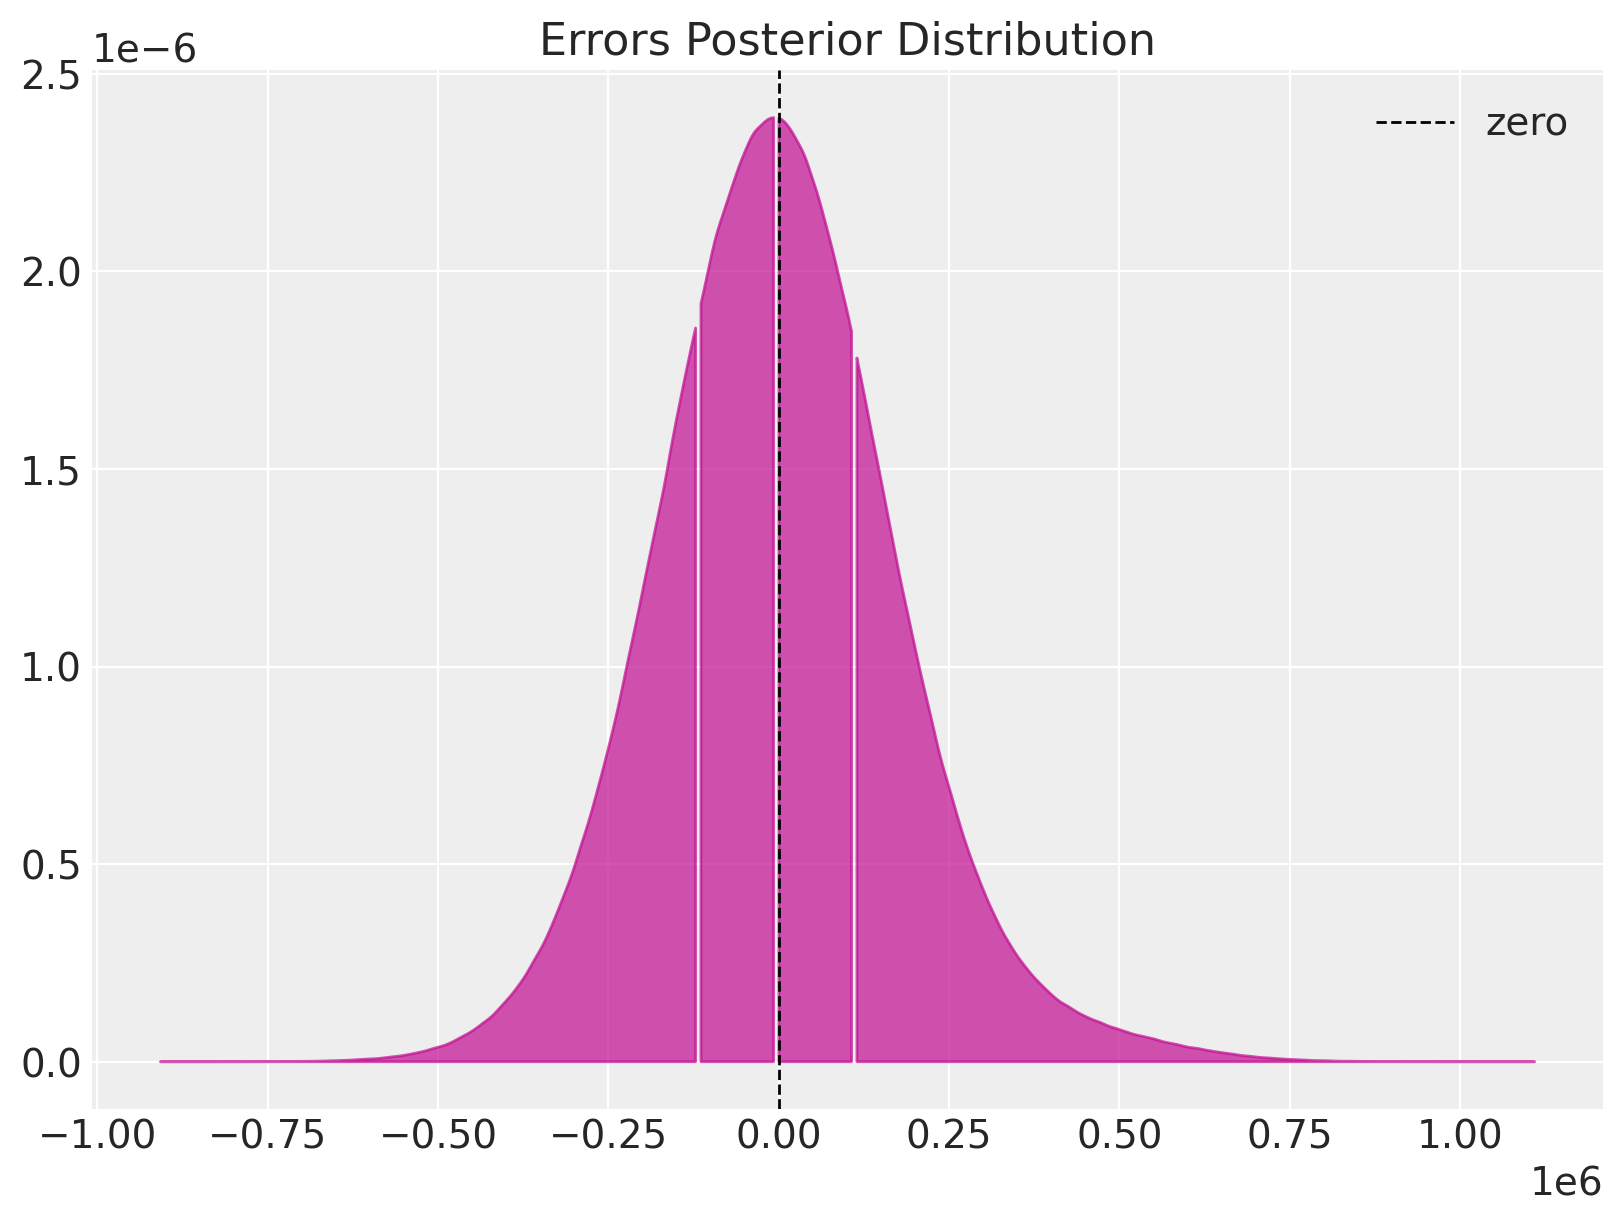

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(
    errors, quantiles=[0.25, 0.5, 0.75], color="C3", fill_kwargs={"alpha": 0.7}, ax=ax
)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1, label="zero")
ax.legend()
ax.set(title="Errors Posterior Distribution");

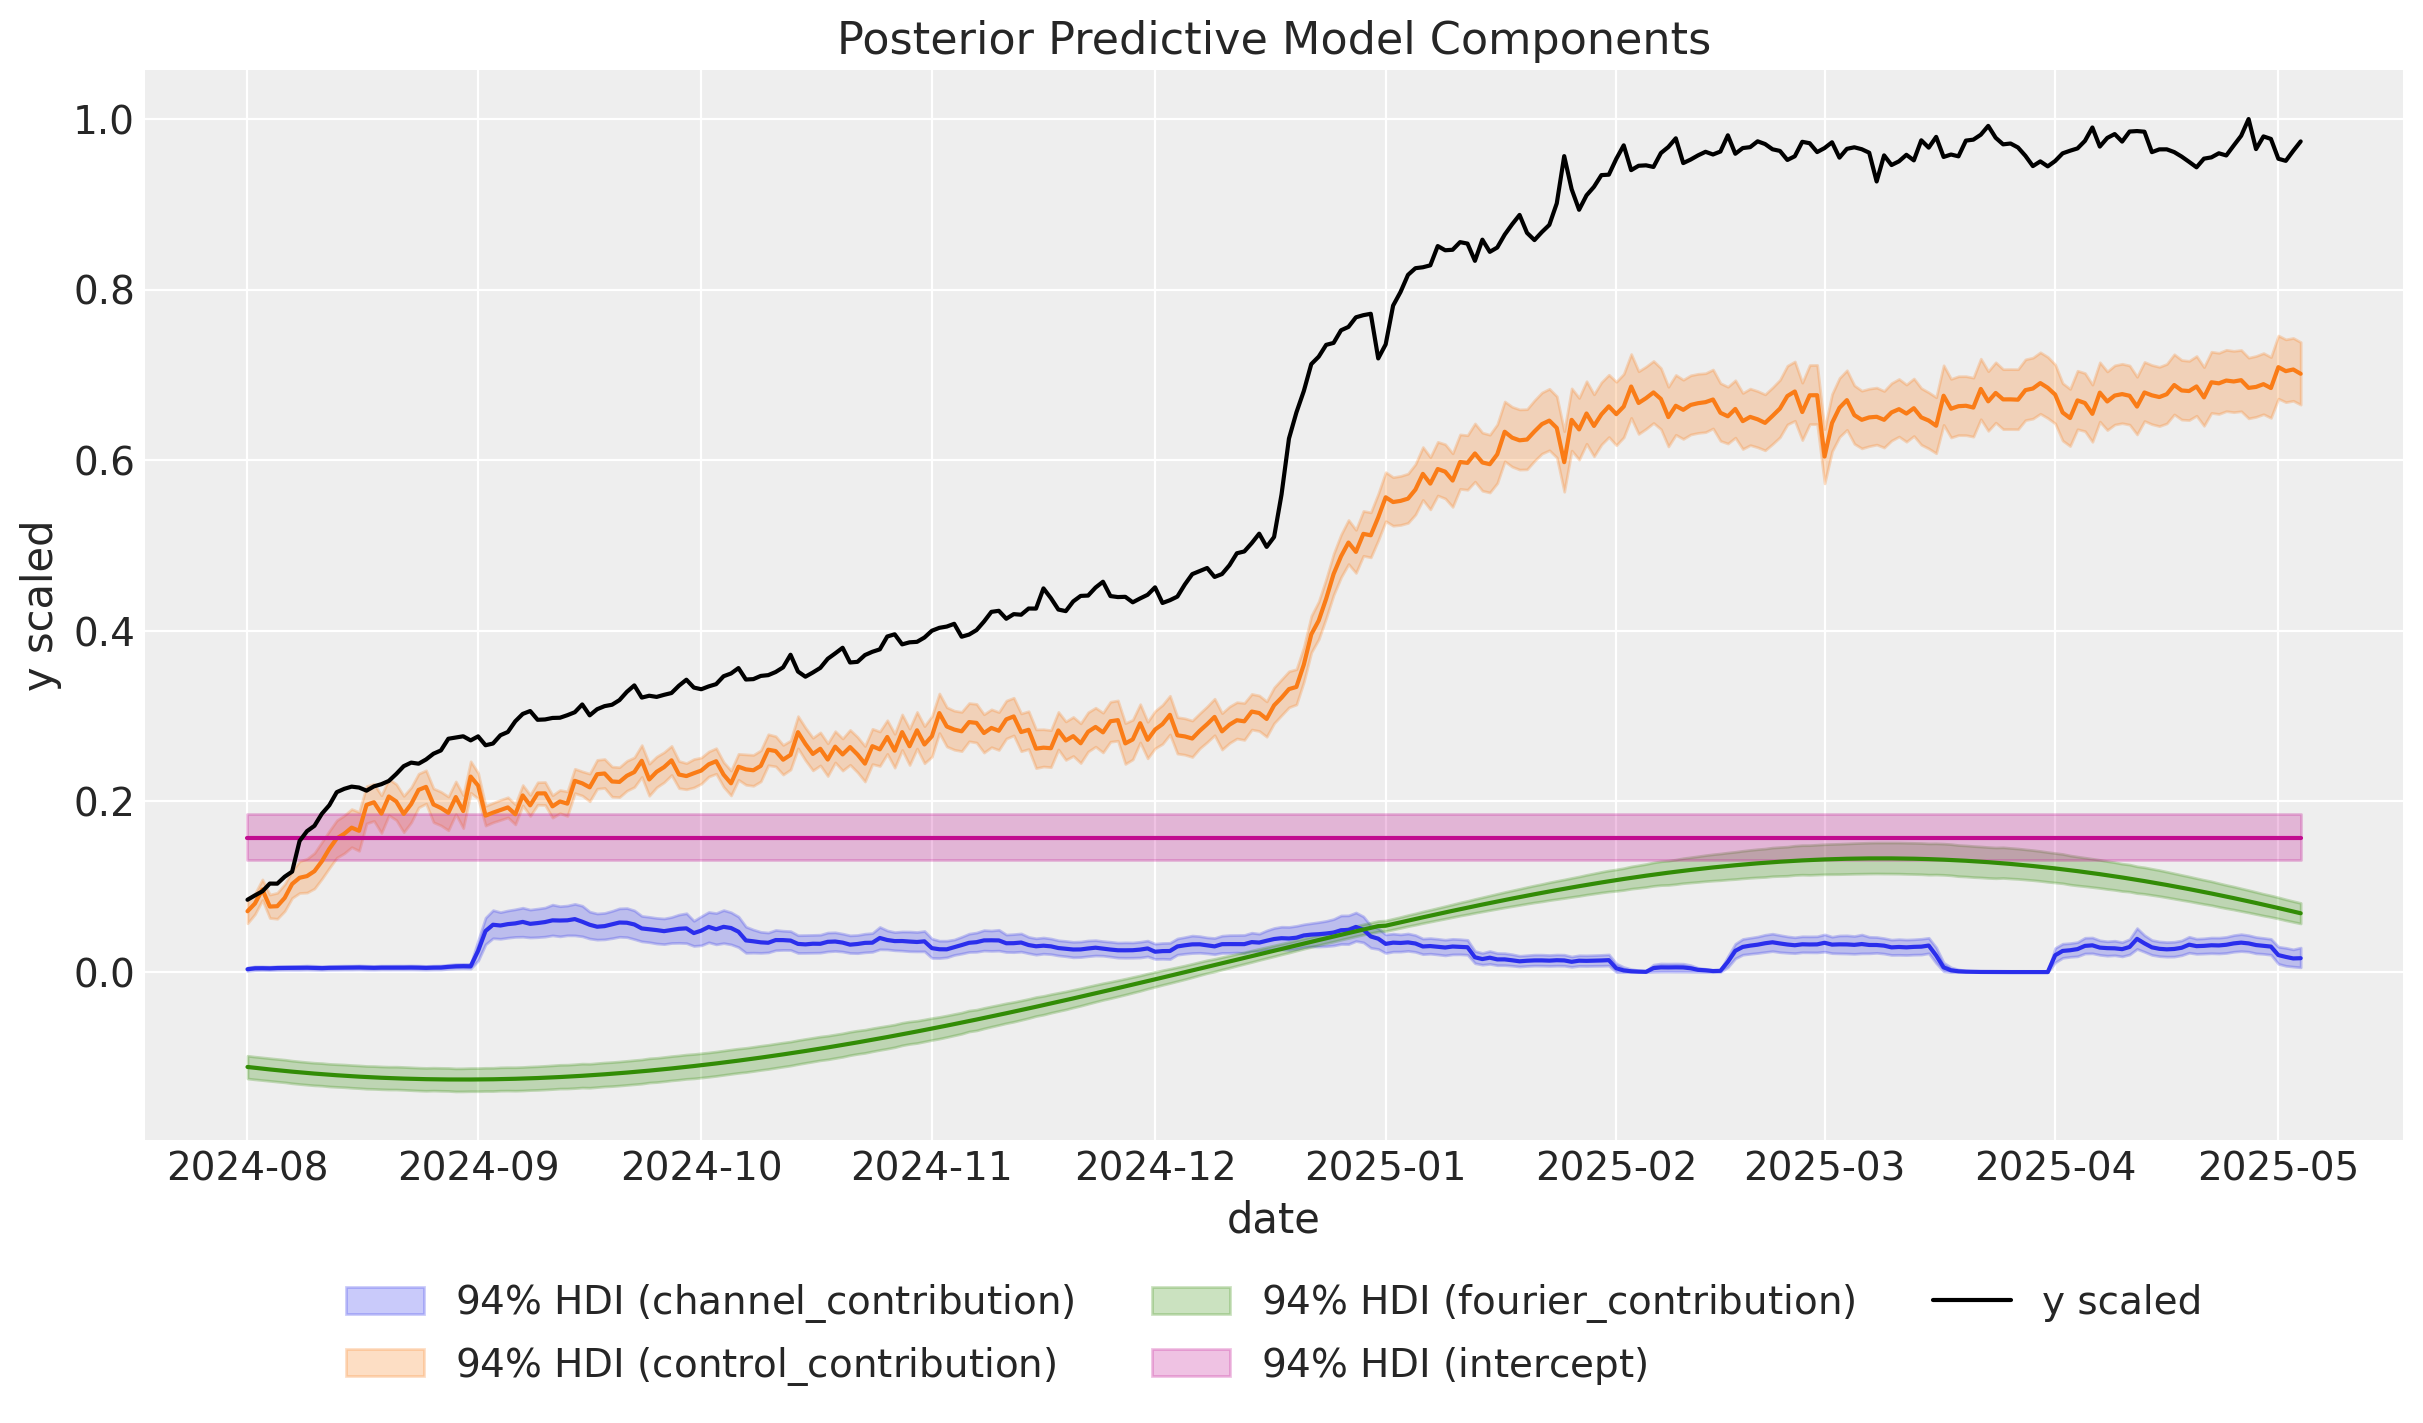

In [45]:
mmm.plot_components_contributions();

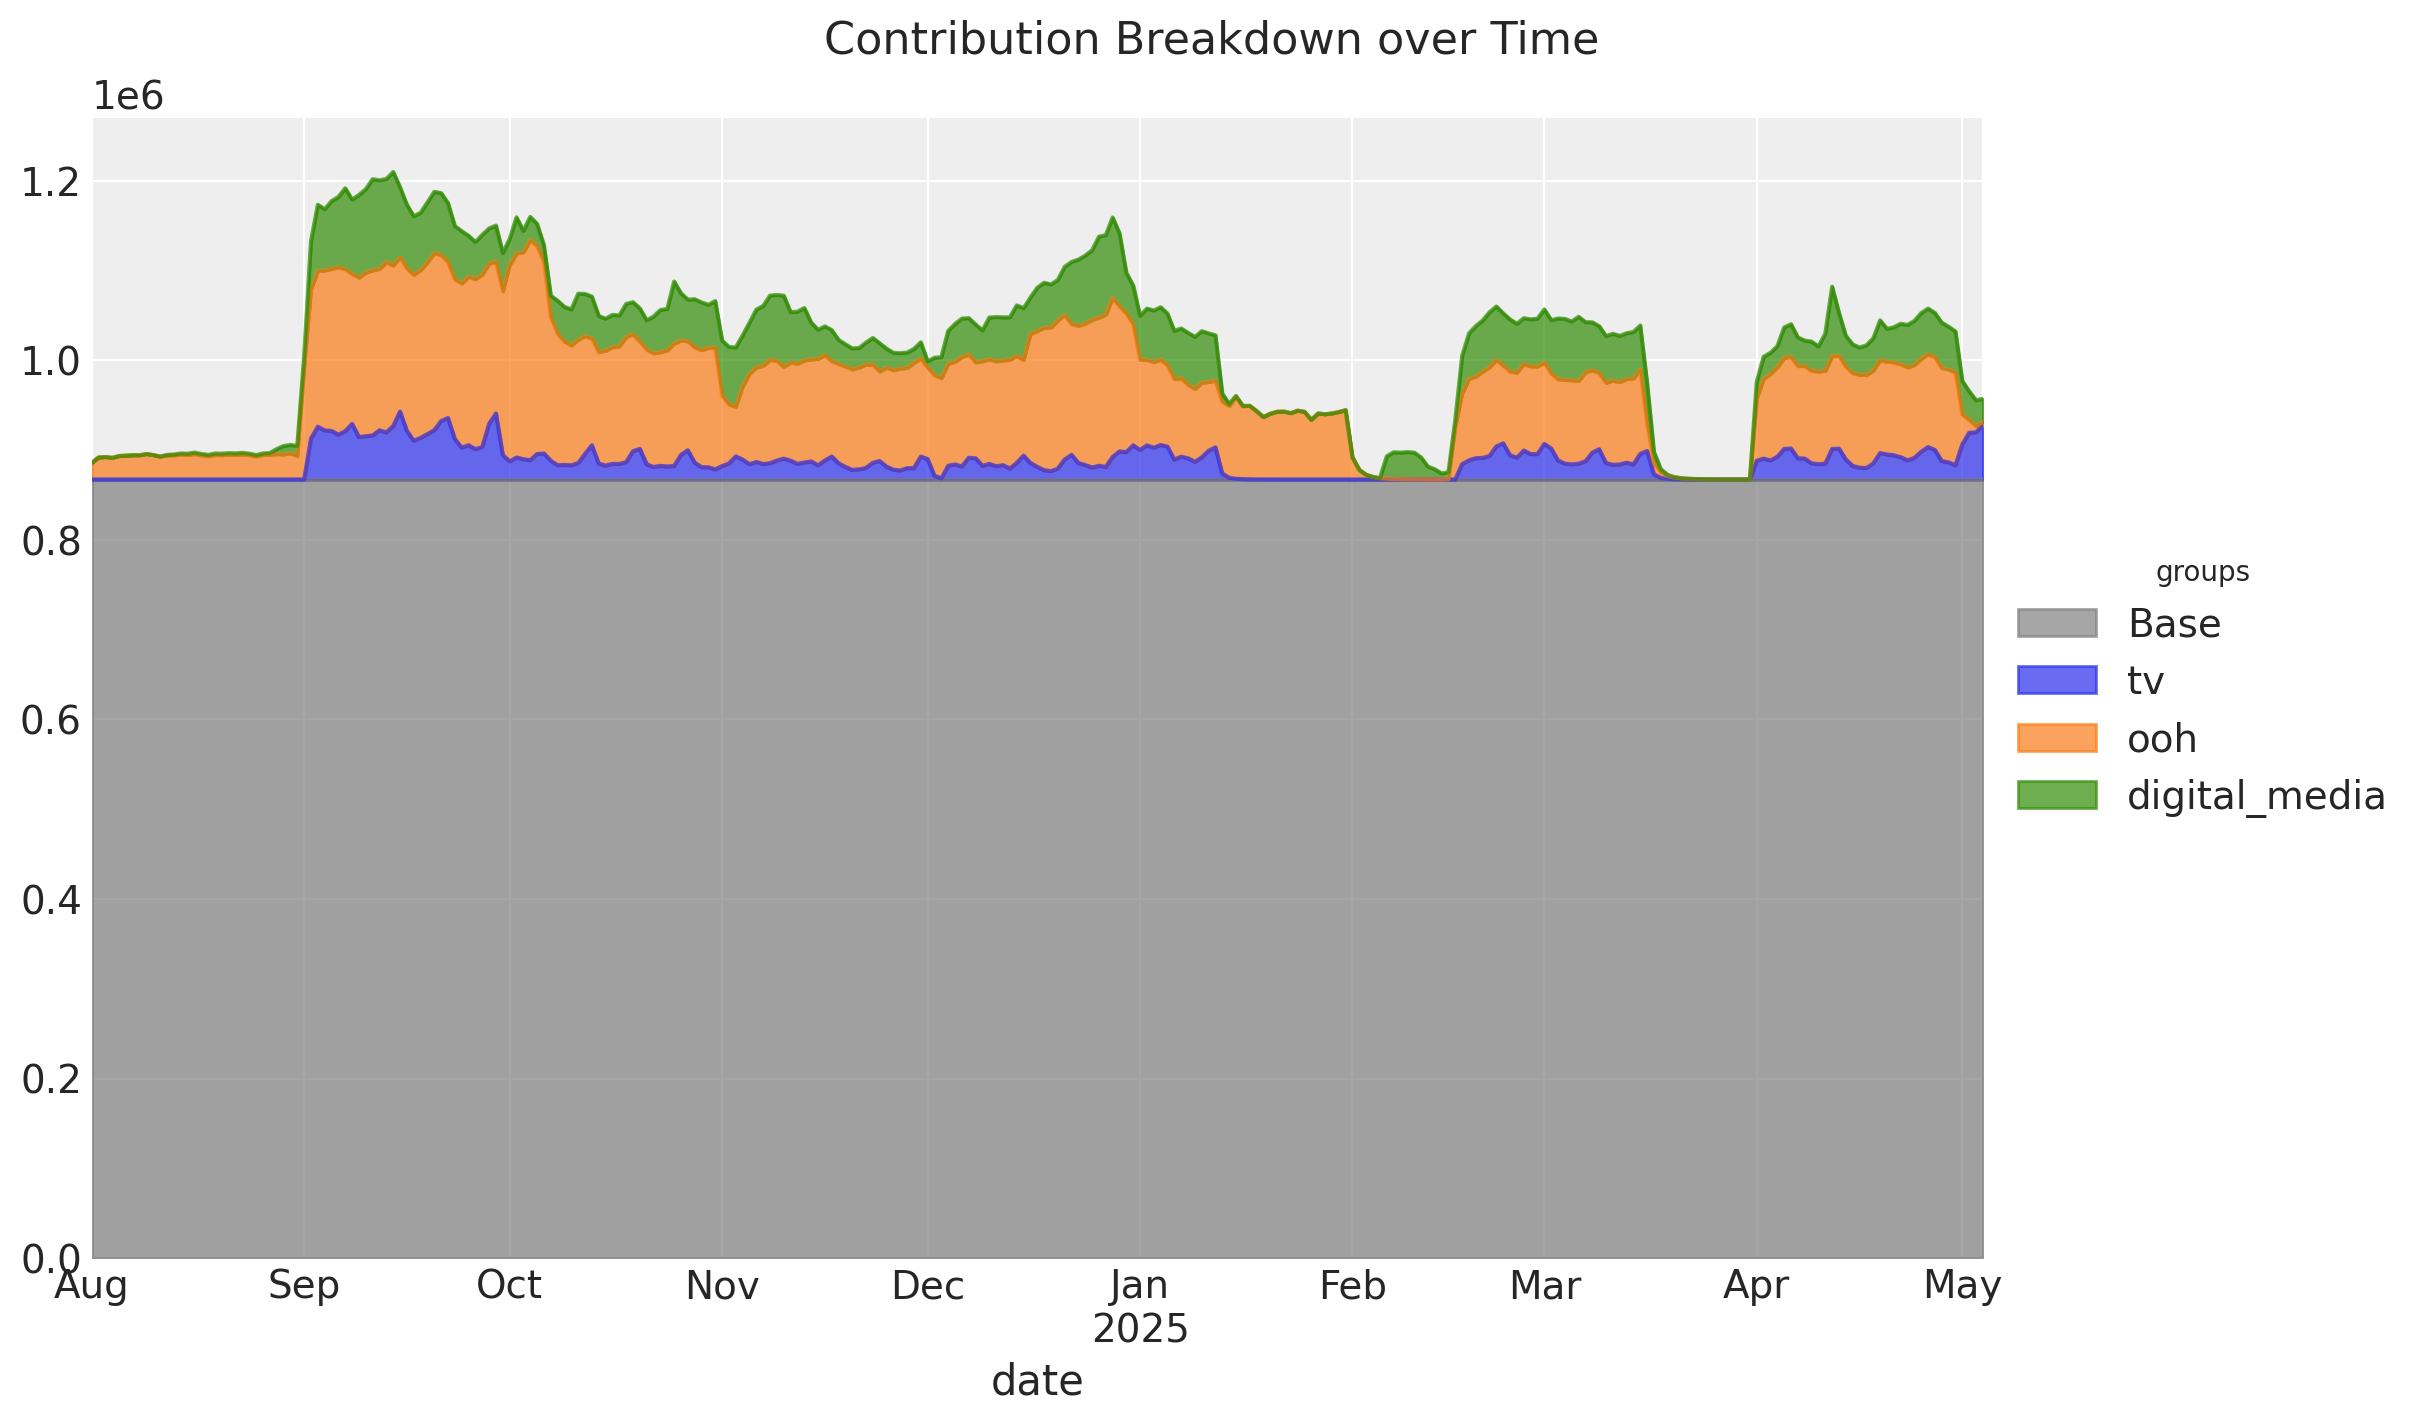

In [46]:
groups = {
    "Base": [
        "intercept",
        # "event_1",
        # "event_2",
        # "yearly_seasonality",
    ],
    "tv": ["tv"],
    "ooh": ["ooh"],
    "digital_media": ["digital_media"],
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "tv": "C0",
            "ooh": "C1",
            "digital_media": "C2",
            "Base": "gray",
            "Seasonality": "black",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

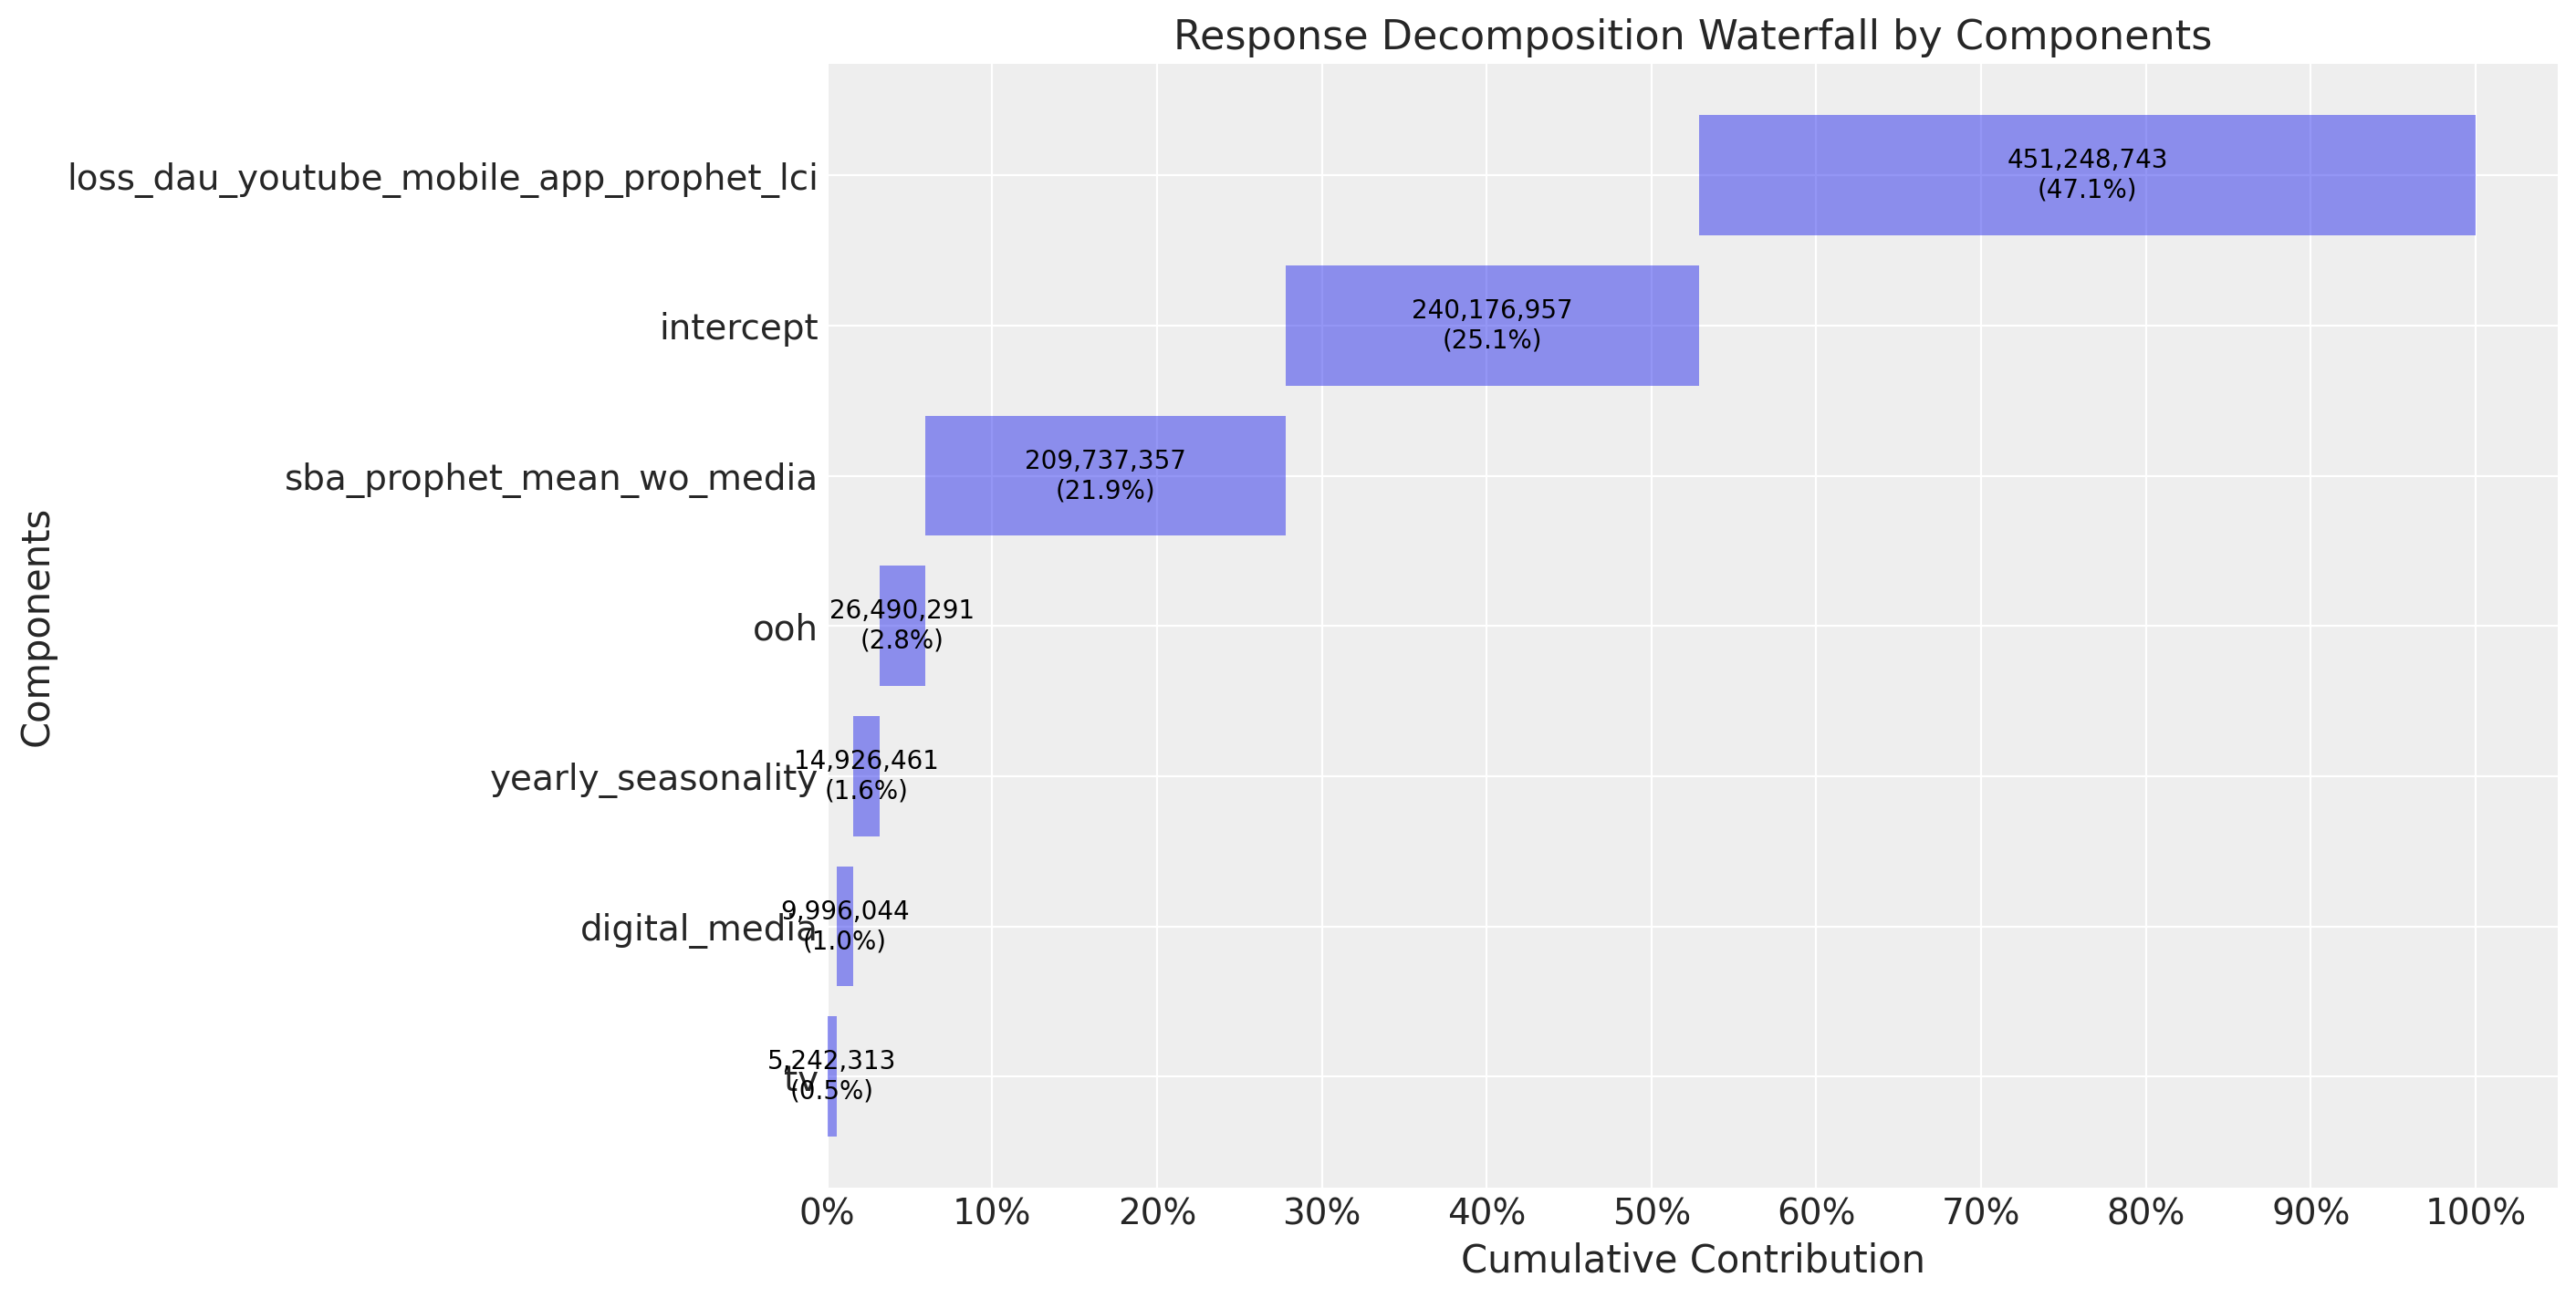

In [47]:
mmm.plot_waterfall_components_decomposition();

In [48]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

tv           ooh  digital_media  \
date                                           
2024-08-01  0.0  18398.257275            0.0   
2024-08-02  0.0  24535.515502            0.0   
2024-08-03  0.0  24954.466705            0.0   
2024-08-04  0.0  24117.713846            0.0   
2024-08-05  0.0  26153.408909            0.0   

            loss_dau_youtube_mobile_app_prophet_lci  \
date                                                  
2024-08-01                             34688.927309   
2024-08-02                            125044.750122   
2024-08-03                            201368.420047   
2024-08-04                             74948.559091   
2024-08-05                             47044.850202   

            sba_prophet_mean_wo_media  yearly_seasonality      intercept  
date                                                                      
2024-08-01              358447.156130      -613197.202585  867064.825913  
2024-08-02              318060.858344      -618730.209062  867064.825913  
2024-08-03              332056.000874      -624070.565456  867064.825913  
2024-08-04              348604.819754      -629217.565372  867064.825913  
2024-08-05              378644.603497      -634170.569909  867064.825913

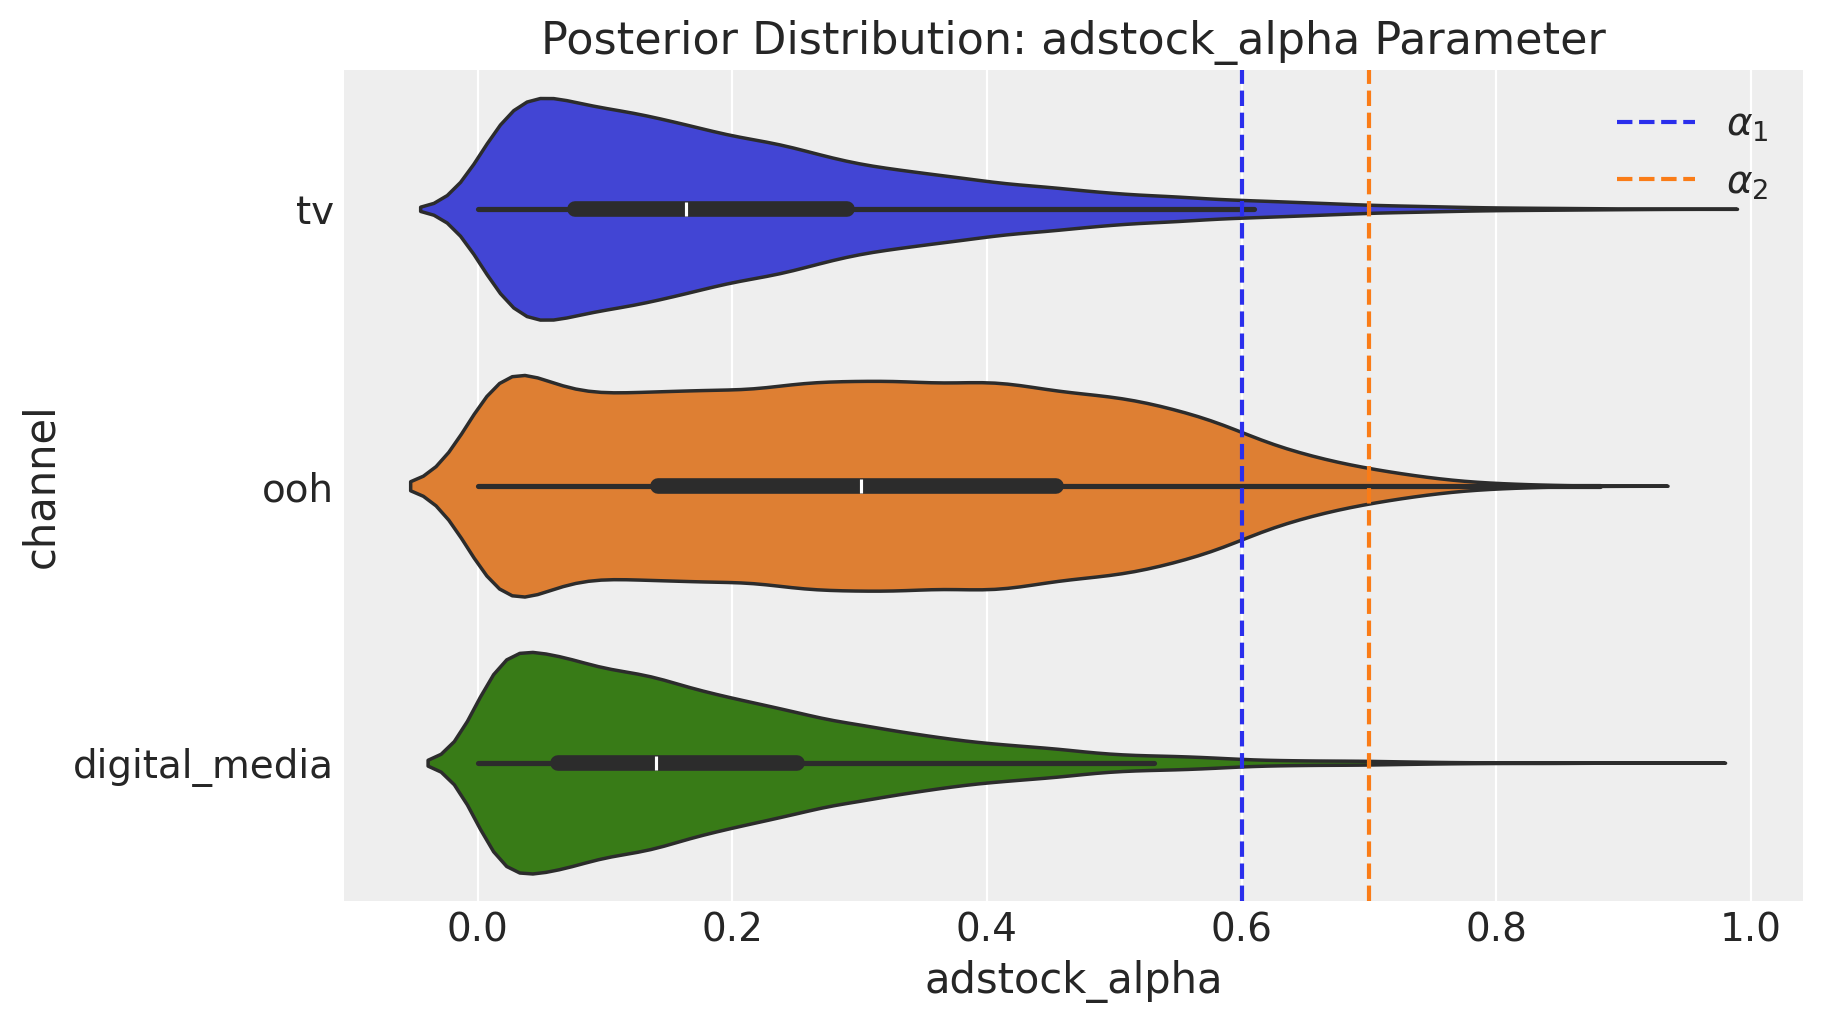

In [49]:
fig = mmm.plot_channel_parameter(param_name="adstock_alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha_tv, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=alpha_ooh, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

In [52]:
get_mean_contributions_over_time_df.loc[date_flight_start:date_flight_end].mean()

tv                                         2.709828e+04
ooh                                        9.102687e+04
digital_media                              3.807617e+04
loss_dau_youtube_mobile_app_prophet_lci    2.796462e+06
sba_prophet_mean_wo_media                  9.589574e+05
yearly_seasonality                         5.410339e+05
intercept                                  8.670648e+05
dtype: float64